# Hidden Markov Model (HMM) Analysis
### Master Thesis: Revisiting Delegation Theory in the Age of AI: Dynamic Algorithm Appreciation and Aversion in Triadic Organizational Relationships

---

### Table of Contents

**Part I — Data and HMM Estimation Framework**

1. [Data Description and Variable Construction](#1-data-description-and-variable-construction)
   - 1.1 &nbsp; [Helpers & Imports](#11-helpers--imports)
   - 1.2 &nbsp; [Benchmark Construction](#12-benchmark-construction)
   - 1.3 &nbsp; [Data Loading & Inspection](#13-data-loading--inspection)
2. [Hidden Markov Model Specification](#2-hidden-markov-model-specification)
   - 2.1 &nbsp; [Model Structure](#21-model-structure)
   - 2.2 &nbsp; [Forward–Backward Algorithm](#22-forwardbackward-algorithm)
   - 2.3 &nbsp; [Maximum Likelihood Estimation](#23-maximum-likelihood-estimation)
3. [Model Selection and Parameter Estimation](#3-model-selection-and-parameter-estimation)
4. [Posterior State Inference and Interpretation](#4-posterior-state-inference-and-interpretation)
   - 4.1 &nbsp; [Posterior State Assignment](#41-posterior-state-assignment)
   - 4.2 &nbsp; [Results Visualisation](#42-results-visualisation)

**Part II — Empirical Findings**

5. [Identification and Characterization of Three Latent Delegation States](#5-identification-and-characterization-of-three-latent-delegation-states)
6. [KPI-Driven Transition Dynamics](#6-kpi-driven-transition-dynamics)
7. [Transparency as Moderator of State Transitions](#7-transparency-as-moderator-of-state-transitions)
8. [Strategic Control Retention Under High Task Stakes](#8-strategic-control-retention-under-high-task-stakes)
9. [Non-Monotonic Relationship Between Delegation and Performance](#9-non-monotonic-relationship-between-delegation-and-performance)
10. [Robustness and Sensitivity Analyses](#10-robustness-and-sensitivity-analyses)

**Part III — Theoretical and Task-Level Implications**

11. [Delegation as Dynamic Learning Process](#11-delegation-as-dynamic-learning-process)
12. [Authority as Strategic and Legitimacy Mechanism](#12-authority-as-strategic-and-legitimacy-mechanism)
13. [Triadic Delegation Flows: Authority vs Execution](#13-triadic-delegation-flows-authority-vs-execution)
14. [Temporal Evolution of Delegation Patterns](#14-temporal-evolution-of-delegation-patterns)

---
# Part I — Data and HMM Estimation Framework

## 1. Data Description and Variable Construction
### 1.1 Helpers & Imports

In [48]:
# ============================================================
# 1. Imports & Helpers
# ============================================================
from __future__ import annotations

import os
import time
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from pathlib import Path
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import logsumexp
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

# ---- resolve data path ----
MANUAL_XLSX_PATH = None
PREFERRED_DATASETS = [
    Path(r"..\triadic_simulation\data\Triadic_Delegation_Dataset_SYNTH_ANALYSIS.xlsx"),
]
DATA_PATH = None
if MANUAL_XLSX_PATH:
    DATA_PATH = Path(MANUAL_XLSX_PATH)
else:
    for p in PREFERRED_DATASETS:
        if p.exists():
            DATA_PATH = p
            break
assert DATA_PATH is not None and DATA_PATH.exists(), \
    f"Data file not found. Tried: {PREFERRED_DATASETS}"
print(f"Data file: {DATA_PATH.resolve()}")


def softmax(z, axis=-1):
    """Numerically stable softmax (works on 1-D vectors and row-wise on 2-D)."""
    z = z - np.max(z, axis=axis, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=axis, keepdims=True)


def log_softmax(z, axis=-1):
    """Numerically stable log-softmax."""
    return z - logsumexp(z, axis=axis, keepdims=True)


def log_gaussian_diag(y, mean, log_sigma):
    """Scalar version (kept for reference)."""
    sigma2 = np.exp(2 * log_sigma)
    return -0.5 * (
        np.sum(np.log(2 * np.pi * sigma2))
        + np.sum((y - mean) ** 2 / sigma2)
    )

print("Section 1 — Imports & helpers loaded.")

Data file: C:\Users\Admin\OneDrive\Desktop\Algorithm-Appreciation-and-Aversion-in-Triadic-Delegation-Settings\triadic_simulation\data\Triadic_Delegation_Dataset_SYNTH_ANALYSIS.xlsx
Section 1 — Imports & helpers loaded.


### 1.2 Benchmark Construction
Derive performance benchmarks used as **transition covariates**:
- `kpi_operational_gap_index` — composite KPI gap
- `within_unit_temporal_benchmark` — period-over-period change
- `horizontal_peer_benchmark` — cross-sectional percentile
- `within_unit_ai_trajectory_benchmark` — deviation from low-AI baseline
- `threshold_benchmark` — recent negative shock indicator

In [49]:
# ============================================================
# 2. Build Benchmarks
# ============================================================

def build_benchmarks(df):
    df = df.sort_values(["manager_id", "period_id"]).copy()

    # Composite performance index (higher = better)
    df["kpi_operational_gap_index"] = (
        (-1.0) * df["service_level_delta"]
        + (-0.6) * df["inventory_cost_delta"]
        + (-0.4) * df["expedite_cost_delta"]
        + (-1.2) * df["error_incident_count"]
    )

    # Within-manager temporal benchmark
    df["within_unit_temporal_benchmark"] = (
        df.groupby("manager_id")["kpi_operational_gap_index"].diff(1)
    )

    # Peer percentile (cross-sectional)
    pct = df.groupby("period_id")["kpi_operational_gap_index"].rank(pct=True)
    df["horizontal_peer_benchmark"] = (pct - 0.5) * 2.0

    # AI trajectory benchmark
    def ai_traj(g):
        q = g["ai_decision_authority_share"].quantile(0.30)
        base = g.loc[
            g["ai_decision_authority_share"] <= q,
            "kpi_operational_gap_index",
        ].mean()
        if np.isnan(base):
            base = g["kpi_operational_gap_index"].mean()
        return g["kpi_operational_gap_index"] - base

    df["within_unit_ai_trajectory_benchmark"] = (
        df.groupby("manager_id", group_keys=False).apply(ai_traj)
    )

    # Threshold shock
    df["threshold_benchmark"] = df["recent_negative_shock"].astype(float)

    # Transparency constant (analysis dataset — no variation)
    df["transparency_moderator"] = 0.0

    return df

print("Section 2 — build_benchmarks() defined.")

Section 2 — build_benchmarks() defined.


### 1.3 Data Loading & Inspection
Load the `panel_manager_period` sheet, build benchmarks, scale variables, and form per-manager sequences.

In [50]:
# ============================================================
# 3. Data Loader
# ============================================================

@dataclass
class HMMData:
    Y: List[np.ndarray]      # emission sequences
    X: List[np.ndarray]      # transition covariates
    Z: List[np.ndarray]      # emission controls
    ids: List[str]
    periods: List[np.ndarray]
    y_scaler: StandardScaler
    x_scaler: StandardScaler
    z_scaler: StandardScaler


def load_sequences(xlsx_path):
    df = pd.read_excel(xlsx_path, sheet_name="panel_manager_period")

    # Safety: analysis file should NOT contain latent truth columns
    forbidden = ["latent_state_true", "latent_state_true_next"]
    if any(c in df.columns for c in forbidden):
        raise ValueError("Use *_ANALYSIS.xlsx dataset (latent states removed).")

    df = build_benchmarks(df)

    emission_cols = ["ai_decision_authority_share", "override_rate"]

    transition_cols = [
        "within_unit_temporal_benchmark",
        "horizontal_peer_benchmark",
        "within_unit_ai_trajectory_benchmark",
        "threshold_benchmark",
        "transparency_moderator",
    ]

    control_cols = [
        "task_complexity_index",
        "demand_volatility",
        "supply_disruption_count",
        "forecast_accuracy_mape",
        "decision_latency_avg",
        "target_difficulty",
        "performance_pressure_index",
        "recent_negative_shock",
    ]

    df = df.dropna(subset=emission_cols + transition_cols + control_cols)

    Y_list, X_list, Z_list = [], [], []
    ids, periods = [], []

    for mid, g in df.groupby("manager_id"):
        g = g.sort_values("period_id")
        Y = g[emission_cols].to_numpy(float)
        X = g[transition_cols].to_numpy(float)
        Z = g[control_cols].to_numpy(float)
        if len(Y) < 3:
            continue
        Y_list.append(Y)
        X_list.append(X)
        Z_list.append(Z)
        ids.append(mid)
        periods.append(g["period_id"].to_numpy())

    y_scaler = StandardScaler().fit(np.vstack(Y_list))
    x_scaler = StandardScaler().fit(np.vstack(X_list))
    z_scaler = StandardScaler().fit(np.vstack(Z_list))

    Y_list = [y_scaler.transform(y) for y in Y_list]
    X_list = [x_scaler.transform(x) for x in X_list]
    Z_list = [z_scaler.transform(z) for z in Z_list]

    return HMMData(Y_list, X_list, Z_list, ids, periods,
                   y_scaler, x_scaler, z_scaler)


# ---- Load & inspect ----
data = load_sequences(DATA_PATH)

seq_lens = [len(y) for y in data.Y]
print(f"Managers loaded : {len(data.Y)}")
print(f"Total observations: {sum(seq_lens)}")
print(f"Sequence lengths : min={min(seq_lens)}, median={int(np.median(seq_lens))}, max={max(seq_lens)}")
print(f"Emission dims (D) : {data.Y[0].shape[1]}")
print(f"Trans. covars (P) : {data.X[0].shape[1]}")
print(f"Controls (K)      : {data.Z[0].shape[1]}")

Managers loaded : 120
Total observations: 3000
Sequence lengths : min=25, median=25, max=25
Emission dims (D) : 2
Trans. covars (P) : 5
Controls (K)      : 8


## 2. Hidden Markov Model Specification
### 2.1 Model Structure & 2.2 Forward–Backward Algorithm
Define the `Params` named-tuple holding all HMM parameters ($\boldsymbol{\mu}$, $\boldsymbol{\Sigma}$, $\boldsymbol{W}$, $\boldsymbol{\alpha}$, $\boldsymbol{\beta}$, $\boldsymbol{\pi}$) and implement the vectorised forward–backward recursion with scaling.

In [51]:
# ============================================================
# 4. Parameters + Forward–Backward  (VECTORIZED)
# ============================================================

@dataclass
class Params:
    logit_pi: np.ndarray   # (J,)
    alpha: np.ndarray      # (J, J)
    beta: np.ndarray       # (J, J, P)
    mu: np.ndarray         # (J, D)
    W: np.ndarray          # (J, D, K)
    log_sigma: np.ndarray  # (J, D)


def _precompute(p, Y, X, Z):
    """Shared emission + transition pre-computation."""
    T, D = Y.shape
    J = p.mu.shape[0]
    means = p.mu[None, :, :] + np.einsum('jdk,tk->tjd', p.W, Z)
    residuals = Y[:, None, :] - means
    sigma2 = np.exp(2 * p.log_sigma)
    log_norm = np.sum(np.log(2 * np.pi * sigma2), axis=1)
    logB = -0.5 * (log_norm[None, :] +
                   np.sum(residuals ** 2 / sigma2[None, :, :], axis=2))
    logits_all = (p.alpha[None, :, :]
                  + np.einsum('ijp,tp->tij', p.beta, X))
    logQ_all = log_softmax(logits_all, axis=2)
    return T, J, logB, logQ_all


def forward_only(p, Y, X, Z):
    """Forward pass only — returns log-likelihood (no posterior). ~2× faster."""
    T, J, logB, logQ_all = _precompute(p, Y, X, Z)
    pi = softmax(p.logit_pi)
    log_alpha = np.empty((T, J))
    log_alpha[0] = np.log(pi) + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(
            log_alpha[t - 1, :, None] + logQ_all[t], axis=0)
    return float(logsumexp(log_alpha[-1]))


def forward_backward(p, Y, X, Z):
    """Full forward–backward returning (ll, log_gamma)."""
    T, J, logB, logQ_all = _precompute(p, Y, X, Z)
    pi = softmax(p.logit_pi)
    log_alpha = np.empty((T, J))
    log_alpha[0] = np.log(pi) + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(
            log_alpha[t - 1, :, None] + logQ_all[t], axis=0)
    ll = logsumexp(log_alpha[-1])

    log_beta = np.zeros((T, J))
    for t in reversed(range(T - 1)):
        log_beta[t] = logsumexp(
            logQ_all[t + 1] + logB[t + 1][None, :] + log_beta[t + 1][None, :],
            axis=1)

    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    return ll, log_gamma

print("Section 4 — Params, forward_only() & forward_backward() defined.")

Section 4 — Params, forward_only() & forward_backward() defined.


### 2.3 Maximum Likelihood Estimation
Estimate models with $J \in \{2, 3, 4\}$ hidden states via two-stage MLE (screening + final refit) and select the best by **BIC**.

In [ ]:
# ============================================================
# LIGHTER SETTINGS VERSION (FAST SCREENING + FINAL REFIT)
#   1) Screening pass: J in [2,3,4] with maxiter=300, n_starts=3, time_cap=8 min per start
#   2) Pick best J among CONVERGED (fallback to lowest BIC overall)
#   3) Final refit only for best J with maxiter=800, n_starts=7, time_cap=20 min per start
#   4) Keeps your callback printing + per-start time cap
# ============================================================

import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import logsumexp

# ------------------------------------------------------------
# Pre-stack all sequences (all same length → 3-D tensors)
# ------------------------------------------------------------
Y_stack = np.stack(data.Y)   # (N, T, D)
X_stack = np.stack(data.X)   # (N, T, P)
Z_stack = np.stack(data.Z)   # (N, T, K)
N, T, D = Y_stack.shape
P = X_stack.shape[2]
K = Z_stack.shape[2]
n_obs_total = N * T
print(f"Batched: {N} managers × {T} periods  (D={D}, P={P}, K={K})")


def fit_model_batched(
    J: int = 3,
    maxiter: int = 300,
    n_starts: int = 3,
    seed: int = 7,
    sigma_min: float = 0.05,
    sigma_max: float = 5.0,
    time_cap_min: int = 8,          # <- lighter: cap each restart (minutes)
    print_every: int = 25,          # <- lighter: print less often
):
    # ----------------------------
    # pack / unpack
    # ----------------------------
    def pack(p):
        return np.concatenate([
            p.logit_pi.ravel(),
            p.alpha.ravel(),
            p.beta.ravel(),
            p.mu.ravel(),
            p.W.ravel(),
            p.log_sigma.ravel(),
        ])

    def unpack(theta):
        idx = 0
        def take(n):
            nonlocal idx
            v = theta[idx:idx+n]
            idx += n
            return v

        return Params(
            logit_pi=take(J),
            alpha=take(J*J).reshape(J, J),
            beta=take(J*J*P).reshape(J, J, P),
            mu=take(J*D).reshape(J, D),
            W=take(J*D*K).reshape(J, D, K),
            log_sigma=take(J*D).reshape(J, D),
        )

    # ----------------------------
    # bounds for log_sigma only
    # ----------------------------
    n_logit_pi = J
    n_alpha = J * J
    n_beta = J * J * P
    n_mu = J * D
    n_W = J * D * K
    n_log_sigma = J * D

    log_sigma_start = n_logit_pi + n_alpha + n_beta + n_mu + n_W
    log_sigma_end = log_sigma_start + n_log_sigma

    total_params = log_sigma_end
    bounds = [(None, None)] * total_params

    LOW, HIGH = np.log(sigma_min), np.log(sigma_max)
    for i in range(log_sigma_start, log_sigma_end):
        bounds[i] = (LOW, HIGH)

    # ----------------------------
    # objective (fully batched)
    # ----------------------------
    def objective(theta):
        p = unpack(theta)

        log_pi = log_softmax(p.logit_pi, axis=0)  # (J,)

        means = p.mu[None, None, :, :] + np.einsum('jdk,ntk->ntjd', p.W, Z_stack)
        resid = Y_stack[:, :, None, :] - means

        sigma2 = np.exp(2.0 * p.log_sigma)
        sigma2 = np.maximum(sigma2, 1e-6)

        log_norm = np.sum(np.log(2.0 * np.pi * sigma2), axis=1)  # (J,)
        logB = -0.5 * (log_norm[None, None, :] +
                       np.sum(resid**2 / sigma2[None, None, :, :], axis=3))  # (N,T,J)

        logQ = log_softmax(
            p.alpha[None, None, :, :] + np.einsum('ijp,ntp->ntij', p.beta, X_stack),
            axis=3
        )

        la = log_pi[None, :] + logB[:, 0, :]
        for t in range(1, T):
            la = logB[:, t, :] + logsumexp(la[:, :, None] + logQ[:, t], axis=1)

        ll = np.sum(logsumexp(la, axis=1))
        return -float(ll)

    # ----------------------------
    # multi-start
    # ----------------------------
    runs = []
    for s in range(n_starts):
        rng = np.random.default_rng(seed + s)

        p0 = Params(
            logit_pi=rng.normal(0, 0.1, J),
            alpha=rng.normal(0, 0.1, (J, J)),
            beta=rng.normal(0, 0.05, (J, J, P)),
            mu=rng.normal(0, 0.5, (J, D)),
            W=rng.normal(0, 0.05, (J, D, K)),
            log_sigma=np.clip(rng.normal(np.log(0.5), 0.2, (J, D)), LOW, HIGH),
        )
        theta0 = pack(p0)

        start_time = time.time()
        iter_counter = {"i": 0}

        def callback(xk):
            iter_counter["i"] += 1
            if iter_counter["i"] % print_every == 0:
                elapsed_min = (time.time() - start_time) / 60
                print(f"    J={J} start {s+1}/{n_starts} iter={iter_counter['i']} "
                      f"elapsed={elapsed_min:.1f} min", flush=True)

            if (time.time() - start_time) > time_cap_min * 60:
                raise TimeoutError("Per-start time cap reached")

        try:
            res = minimize(
                objective,
                theta0,
                method="L-BFGS-B",
                bounds=bounds,
                callback=callback,
                options={
                    "maxiter": maxiter,
                    "maxfun": 8000,     # <- lighter than 20000
                    "ftol": 1e-8,       # <- lighter than 1e-9
                }
            )
            runs.append((unpack(res.x), res))
            print(f"    done: J={J} start {s+1}/{n_starts} success={res.success} "
                  f"nit={getattr(res,'nit',None)} fun={res.fun:.2f} msg={res.message}",
                  flush=True)
        except TimeoutError:
            print(f"    STOPPED: J={J} start {s+1}/{n_starts} (time cap {time_cap_min}m)",
                  flush=True)
            continue

    if len(runs) == 0:
        raise RuntimeError(f"All starts timed out / failed for J={J}. Increase time_cap_min.")

    converged = [(p_hat, r) for (p_hat, r) in runs if r.success]
    if len(converged) > 0:
        best_p, best_res = min(converged, key=lambda t: t[1].fun)
        best_is_converged = True
    else:
        best_p, best_res = min(runs, key=lambda t: t[1].fun)
        best_is_converged = False

    return best_p, best_res, best_is_converged


# ============================================================
# STAGE 1: FAST SCREENING 
# ============================================================
screen_results = []
best_J_screen = None
best_bic_screen = np.inf
best_model_screen = None

print("\n=== STAGE 1: Screening (maxiter=300, n_starts=3) ===")
for J in [2, 3, 4]:
    print(f"\n[Screen] Fitting J={J} ...", flush=True)
    t0 = time.time()

    p_hat, res, is_conv = fit_model_batched(
        J=J,
        maxiter=300,
        n_starts=3,
        seed=7,
        sigma_min=0.05,
        sigma_max=5.0,
        time_cap_min=8,     # <- cap each start to keep things moving
        print_every=25
    )

    elapsed = time.time() - t0
    ll_total = -res.fun
    k = len(res.x)
    bic = np.log(n_obs_total) * k - 2 * ll_total
    aic = 2 * k - 2 * ll_total

    screen_results.append({
        "stage": "screen",
        "J": J,
        "params": k,
        "LL": ll_total,
        "AIC": aic,
        "BIC": bic,
        "converged": bool(res.success),
        "selected_converged_run": bool(is_conv),
        "time_s": elapsed,
        "message": str(res.message),
    })

    print(f"[Screen] J={J} LL={ll_total:.1f} BIC={bic:.1f} params={k} "
          f"{'✓' if res.success else '✗'} ({elapsed/60:.1f} min)")
    print(f"         message: {res.message}")

# prefer best among converged; else best overall
df_screen = pd.DataFrame(screen_results)
df_conv = df_screen[df_screen["converged"] == True]
if len(df_conv) > 0:
    best_row = df_conv.loc[df_conv["BIC"].idxmin()]
else:
    best_row = df_screen.loc[df_screen["BIC"].idxmin()]
    print("\n⚠️ Screening: none converged. Picking lowest BIC anyway (non-converged).")

best_J_screen = int(best_row["J"])
best_bic_screen = float(best_row["BIC"])
print(f"\n★ Screening winner: J={best_J_screen} (BIC={best_bic_screen:.1f})")


# ============================================================
# STAGE 2: FINAL REFIT (only for the winning J)
# ============================================================
print(f"\n=== STAGE 2: Final refit for J={best_J_screen} (maxiter=800, n_starts=7) ===")
t0 = time.time()

best_p, best_res, best_is_conv = fit_model_batched(
    J=best_J_screen,
    maxiter=800,
    n_starts=7,
    seed=77,
    sigma_min=0.05,
    sigma_max=5.0,
    time_cap_min=20,   # allow longer for final
    print_every=25
)

elapsed = time.time() - t0
ll_total = -best_res.fun
k = len(best_res.x)
bic = np.log(n_obs_total) * k - 2 * ll_total
aic = 2 * k - 2 * ll_total

final_row = {
    "stage": "final",
    "J": best_J_screen,
    "params": k,
    "LL": ll_total,
    "AIC": aic,
    "BIC": bic,
    "converged": bool(best_res.success),
    "selected_converged_run": bool(best_is_conv),
    "time_s": elapsed,
    "message": str(best_res.message),
}

print(f"\n[Final] J={best_J_screen} LL={ll_total:.1f} AIC={aic:.1f} BIC={bic:.1f} "
      f"params={k} {'✓' if best_res.success else '✗'} ({elapsed/60:.1f} min)")
print(f"        message: {best_res.message}")

# ============================================================
# Show combined results
# ============================================================
df_all = pd.concat([df_screen, pd.DataFrame([final_row])], ignore_index=True)
df_all = df_all.round({"LL": 1, "AIC": 1, "BIC": 1, "time_s": 1})
display(df_all)

print(f"\n★ Best model after final refit: J={best_J_screen}  (BIC={bic:.1f})")


Batched: 120 managers × 25 periods  (D=2, P=5, K=8)

=== STAGE 1: Screening (maxiter=300, n_starts=3) ===

[Screen] Fitting J=2 ...
    J=2 start 1/3 iter=25 elapsed=0.3 min
    J=2 start 1/3 iter=50 elapsed=0.5 min
    J=2 start 1/3 iter=75 elapsed=0.8 min
    J=2 start 1/3 iter=100 elapsed=1.0 min
    done: J=2 start 1/3 success=False nit=115 fun=-1427.95 msg=STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
    J=2 start 2/3 iter=25 elapsed=0.3 min
    J=2 start 2/3 iter=50 elapsed=0.6 min
    J=2 start 2/3 iter=75 elapsed=0.9 min
    J=2 start 2/3 iter=100 elapsed=1.1 min
    done: J=2 start 2/3 success=False nit=108 fun=-2570.89 msg=STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
    J=2 start 3/3 iter=25 elapsed=0.3 min
    J=2 start 3/3 iter=50 elapsed=0.6 min
    J=2 start 3/3 iter=75 elapsed=0.8 min
    J=2 start 3/3 iter=100 elapsed=1.1 min
    done: J=2 start 3/3 success=False nit=113 fun=-2571.05 msg=STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
[Screen] J=2 LL=2571.0 BI

,stage,J,params,LL,AIC,BIC,converged,selected_converged_run,time_s,message
0,screen,2,66,2571.0,-5010.1,-4613.7,False,False,217.6,"STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT"
1,screen,3,117,3504.5,-6775.1,-6072.3,False,False,294.8,"STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT"
2,screen,4,180,3252.6,-6145.2,-5064.1,False,False,345.8,"STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT"
3,final,3,117,3406.9,-6579.8,-5877.0,False,False,677.3,"STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT"



★ Best model after final refit: J=3  (BIC=-5877.0)


## 3. Model Selection and Parameter Estimation
Print the emission means, standard deviations, initial state distribution, transition intercepts, and covariate coefficients for the BIC-selected model ($J^* = 3$).

In [57]:
# ============================================================
# 6. Inspect Estimated Parameters
# ============================================================

# Bridge variable names from the two-stage fitting cell
best_model = best_p
best_J = best_J_screen

emission_cols = ["ai_decision_authority_share", "override_rate"]

# Un-standardise emission means & sigmas for interpretation
mu_orig = data.y_scaler.inverse_transform(best_model.mu)
sigma_orig = np.exp(best_model.log_sigma) * data.y_scaler.scale_

print(f"Best model: J={best_J} hidden states\n")

# Emission parameters
em_rows = []
for j in range(best_J):
    for d, col in enumerate(emission_cols):
        em_rows.append({
            "State": j + 1,
            "Variable": col,
            "Mean (orig scale)": round(mu_orig[j, d], 4),
            "Std (orig scale)": round(sigma_orig[j, d], 4),
        })
em_df = pd.DataFrame(em_rows)
print("── Emission Parameters ──")
display(em_df)

# Initial-state distribution
pi = softmax(best_model.logit_pi)
print("\n── Initial State Distribution ──")
for j in range(best_J):
    print(f"  π(state {j+1}) = {pi[j]:.4f}")

# Transition intercepts
print("\n── Transition Intercept Matrix (α) ──")
alpha_df = pd.DataFrame(
    np.round(best_model.alpha, 3),
    index=[f"from {j+1}" for j in range(best_J)],
    columns=[f"to {j+1}" for j in range(best_J)])
display(alpha_df)

Best model: J=3 hidden states

── Emission Parameters ──


,State,Variable,Mean (orig scale),Std (orig scale)
0,1,ai_decision_authority_share,0.3926,0.0270
1,1,override_rate,0.6078,0.0288
2,2,ai_decision_authority_share,0.4567,0.0185
3,2,override_rate,0.5431,0.0177
4,3,ai_decision_authority_share,0.5244,0.0278
5,3,override_rate,0.4761,0.0271



── Initial State Distribution ──
  π(state 1) = 0.3101
  π(state 2) = 0.3819
  π(state 3) = 0.3079

── Transition Intercept Matrix (α) ──


,to 1,to 2,to 3
from 1,0.208,-0.413,0.132
from 2,-0.869,1.252,-0.053
from 3,-0.222,0.172,0.144


## 4. Posterior State Inference and Interpretation
### 4.1 Posterior State Assignment
Run the forward–backward algorithm on every manager with the best model and produce a posterior CSV file. This posterior probabilities show managers switching between the 3 regimes over time, compute "% of time in each state", compare performance outcomes by inferred state.

In [58]:
# ============================================================
# 7. Posterior State Assignment
# ============================================================

rows = []
for mid, periods, Y, X, Z in zip(data.ids, data.periods,
                                   data.Y, data.X, data.Z):
    ll, log_gamma = forward_backward(best_model, Y, X, Z)
    gamma = np.exp(log_gamma)
    states = gamma.argmax(axis=1) + 1
    for t in range(len(Y)):
        row = {"manager_id": mid, "period_id": periods[t],
               "most_likely_state": states[t]}
        for j in range(gamma.shape[1]):
            row[f"posterior_state_{j+1}"] = gamma[t, j]
        rows.append(row)

posteriors = pd.DataFrame(rows)

out_path = Path("hmm_posteriors.csv")
posteriors.to_csv(out_path, index=False)
print(f"Posterior file saved → {out_path.resolve()}")
print(f"Shape: {posteriors.shape}")
display(posteriors.head(10))

# State frequency
print("\n── State Frequency ──")
freq = posteriors["most_likely_state"].value_counts().sort_index()
for s, n in freq.items():
    print(f"  State {s}: {n:,} obs ({n/len(posteriors)*100:.1f}%)")

Posterior file saved → C:\Users\Admin\OneDrive\Desktop\Algorithm-Appreciation-and-Aversion-in-Triadic-Delegation-Settings\data_analysis\hmm_posteriors.csv
Shape: (3000, 6)


,manager_id,period_id,most_likely_state,posterior_state_1,posterior_state_2,posterior_state_3
0,M0001,2,2,1.149377e-04,9.876587e-01,1.222633e-02
1,M0001,3,2,9.554296e-02,9.044294e-01,2.763191e-05
2,M0001,4,1,9.999998e-01,1.596037e-07,1.676792e-12
3,M0001,5,3,9.451525e-07,3.950032e-01,6.049959e-01
4,M0001,6,2,4.173950e-04,9.578462e-01,4.173640e-02
5,M0001,7,1,1.000000e+00,1.248143e-19,2.245081e-22
6,M0001,8,2,4.230578e-02,9.496767e-01,8.017521e-03
7,M0001,9,2,4.790424e-06,9.777175e-01,2.227769e-02
8,M0001,10,2,1.245213e-02,9.871639e-01,3.839656e-04
9,M0001,11,3,8.513074e-11,1.439298e-05,9.999856e-01



── State Frequency ──
  State 1: 794 obs (26.5%)
  State 2: 1,288 obs (42.9%)
  State 3: 918 obs (30.6%)


#### Conclusions:

1. The dominant managerial posture is cautious middle-ground delegation, not outright aversion or appreciation.
2. Posteriors are extremely sharp (near 0 or 1), meaning the 3-state model cleanly separates the data with high classification confidence.
3. Even a single manager (M0001) traverses all three states within 10 periods, confirming delegation states are dynamic regimes, not fixed traits — exactly what the covariate-driven HMM is designed to capture.

### 4.2 Results Visualisation

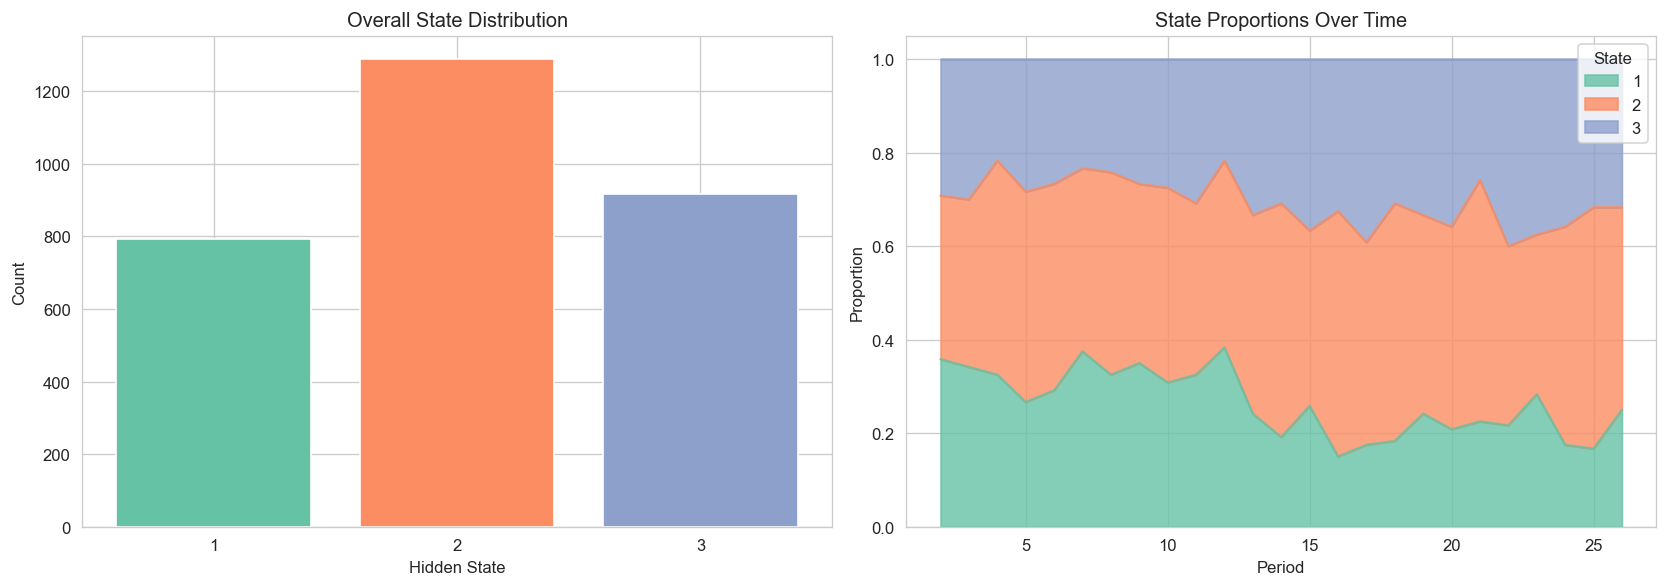

In [59]:
# ============================================================
# 8a. State distribution over time
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: overall state proportions
freq = posteriors["most_likely_state"].value_counts().sort_index()
axes[0].bar(freq.index.astype(str), freq.values, color=sns.color_palette("Set2", best_J))
axes[0].set_xlabel("Hidden State")
axes[0].set_ylabel("Count")
axes[0].set_title("Overall State Distribution")

# Stacked area: state proportions by period
pivot = (posteriors.groupby(["period_id", "most_likely_state"])
         .size().unstack(fill_value=0))
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)
pivot_pct.plot.area(ax=axes[1], stacked=True, alpha=0.8,
                     color=sns.color_palette("Set2", best_J))
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Proportion")
axes[1].set_title("State Proportions Over Time")
axes[1].legend(title="State", loc="upper right")

plt.tight_layout()
plt.show()

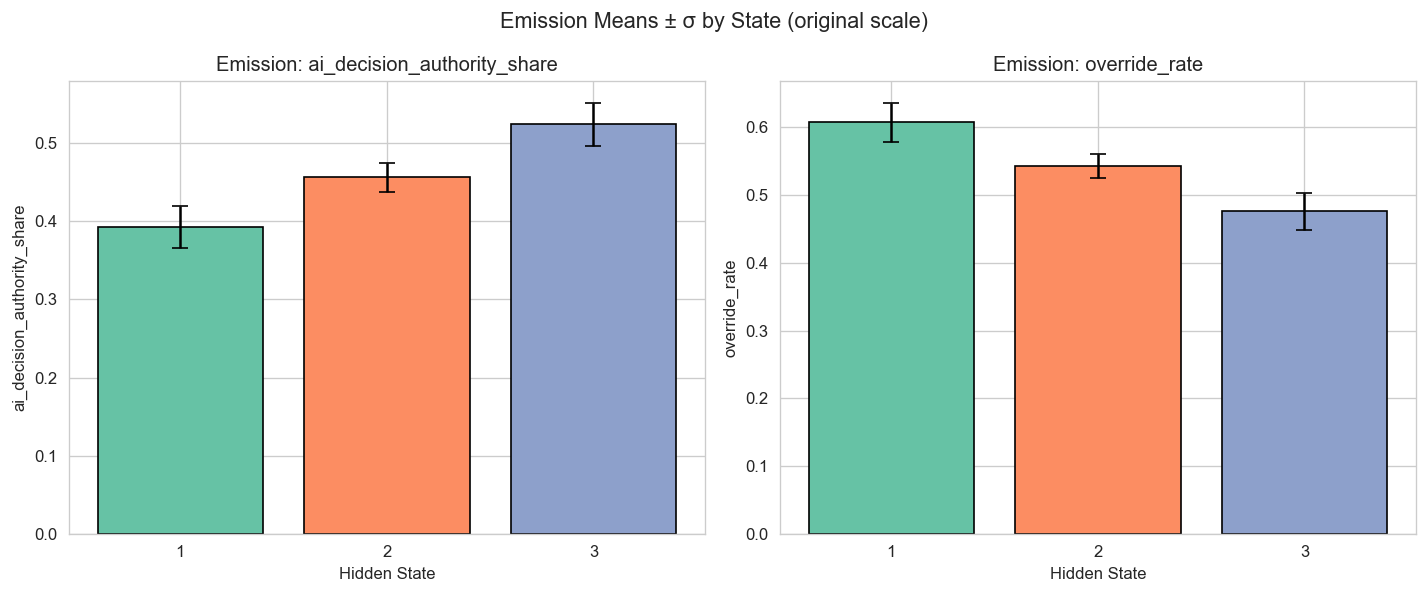

In [60]:
# ============================================================
# 8b. Emission means by state (original scale)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for d, col in enumerate(emission_cols):
    ax = axes[d]
    vals = [mu_orig[j, d] for j in range(best_J)]
    errs = [sigma_orig[j, d] for j in range(best_J)]
    x = np.arange(best_J) + 1
    ax.bar(x.astype(str), vals, yerr=errs, capsize=5,
           color=sns.color_palette("Set2", best_J), edgecolor="k")
    ax.set_xlabel("Hidden State")
    ax.set_ylabel(col)
    ax.set_title(f"Emission: {col}")

plt.suptitle("Emission Means ± σ by State (original scale)", fontsize=13)
plt.tight_layout()
plt.show()

#### Conclusions: 


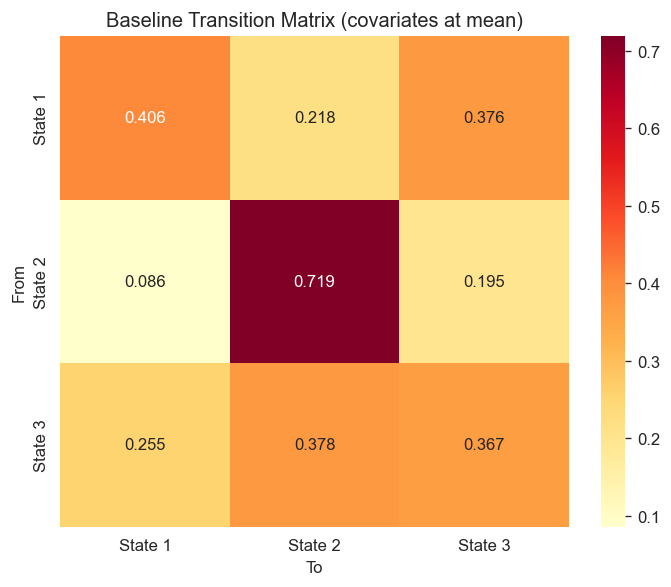


Transition probabilities (rows sum to 1):
  From state 1: [0.406 0.218 0.376]
  From state 2: [0.086 0.719 0.195]
  From state 3: [0.255 0.378 0.367]


In [61]:
# ============================================================
# 8c. Transition matrix heatmap (baseline, at X=0)
# ============================================================

# Baseline transition matrix (covariates at their mean = 0 after scaling)
Q_base = np.zeros((best_J, best_J))
for k in range(best_J):
    logits = best_model.alpha[k]  # beta @ 0 = 0
    Q_base[k] = softmax(logits)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(Q_base, annot=True, fmt=".3f", cmap="YlOrRd",
            xticklabels=[f"State {j+1}" for j in range(best_J)],
            yticklabels=[f"State {j+1}" for j in range(best_J)],
            ax=ax)
ax.set_xlabel("To")
ax.set_ylabel("From")
ax.set_title("Baseline Transition Matrix (covariates at mean)")
plt.tight_layout()
plt.show()

print("\nTransition probabilities (rows sum to 1):")
for k in range(best_J):
    probs = " ".join(f"{Q_base[k,j]:.3f}" for j in range(best_J))
    print(f"  From state {k+1}: [{probs}]")

#### Conclusions: 
1. State 2 (Transitionary) is the most stable regime with the probability of staying is 71.9% suggesting conditional delegation or manager-in-the-lopp is the equilibrium governance regime and is structually central.Moreover, at State 2, managers move upward more than downward (to State 3: 19.5% and to State 1: 8.6%), they are testing AI with guardrails, they delegate half of the time while maintaining moderate override. Each period where this works accumulates positive evidence, overtime , the natural direction is towards more trust. Peer benchmarks amplify its (The β for horizontal_peer_benchmark from State 2 → State 1 is −0.054 (a negative shock pushes away from aversion), while from State 2 → State 3 is −0.017 (nearly neutral)). Seeing peers perform well with AI makes falling into aversion even less likely.
2. From State 1 (Aversion Dominant) 40.6% stay and 37.6% jump directly to State 3 (Appreciation Dominant). This can be explained by peer pressure, The ß coefficient for horizontal_peer_benchmark from State 1 to State 3 is +0.134 suggesting that when an aversion mode manager sees peers outperforming them, because peer are delegating to AI, competive pressure pushes them to match peer-level AI delegation immediately. Moreover, State 1 is reactive state, not a stable regime, when triggering shock passes (bad forecast corrects, a supply disruption resolves), the manager has simultaneously observe that AI recommendations were reasonable and accumulated trust-relevant evident. This create rebound effect directly towards appreciation. 
3.  State 3 - Apreciation Dominant is the least stable, only 36.7% stay, 37.8% move back to State 2 and 25.5% rever to State 1, manager often recalibrate downward. Manager in State 3 has delegated heavily (AI authority is 0.524). Every new period is new test if AI recommendations produce a bad forecast (high MAPE), a supply disruption or a missed target, the managers trust take a direct hit. State 1 has no such exposure, manager is always overriding, so AI errors don´t threaten their stance. It is also interesting to see from ß coefficients that when manager falls below performacne threshold, appreciation managers get pushed towards aversions and positive performance trend actually pulls them back towards cautious middle rather then reinforcing high delegation. 


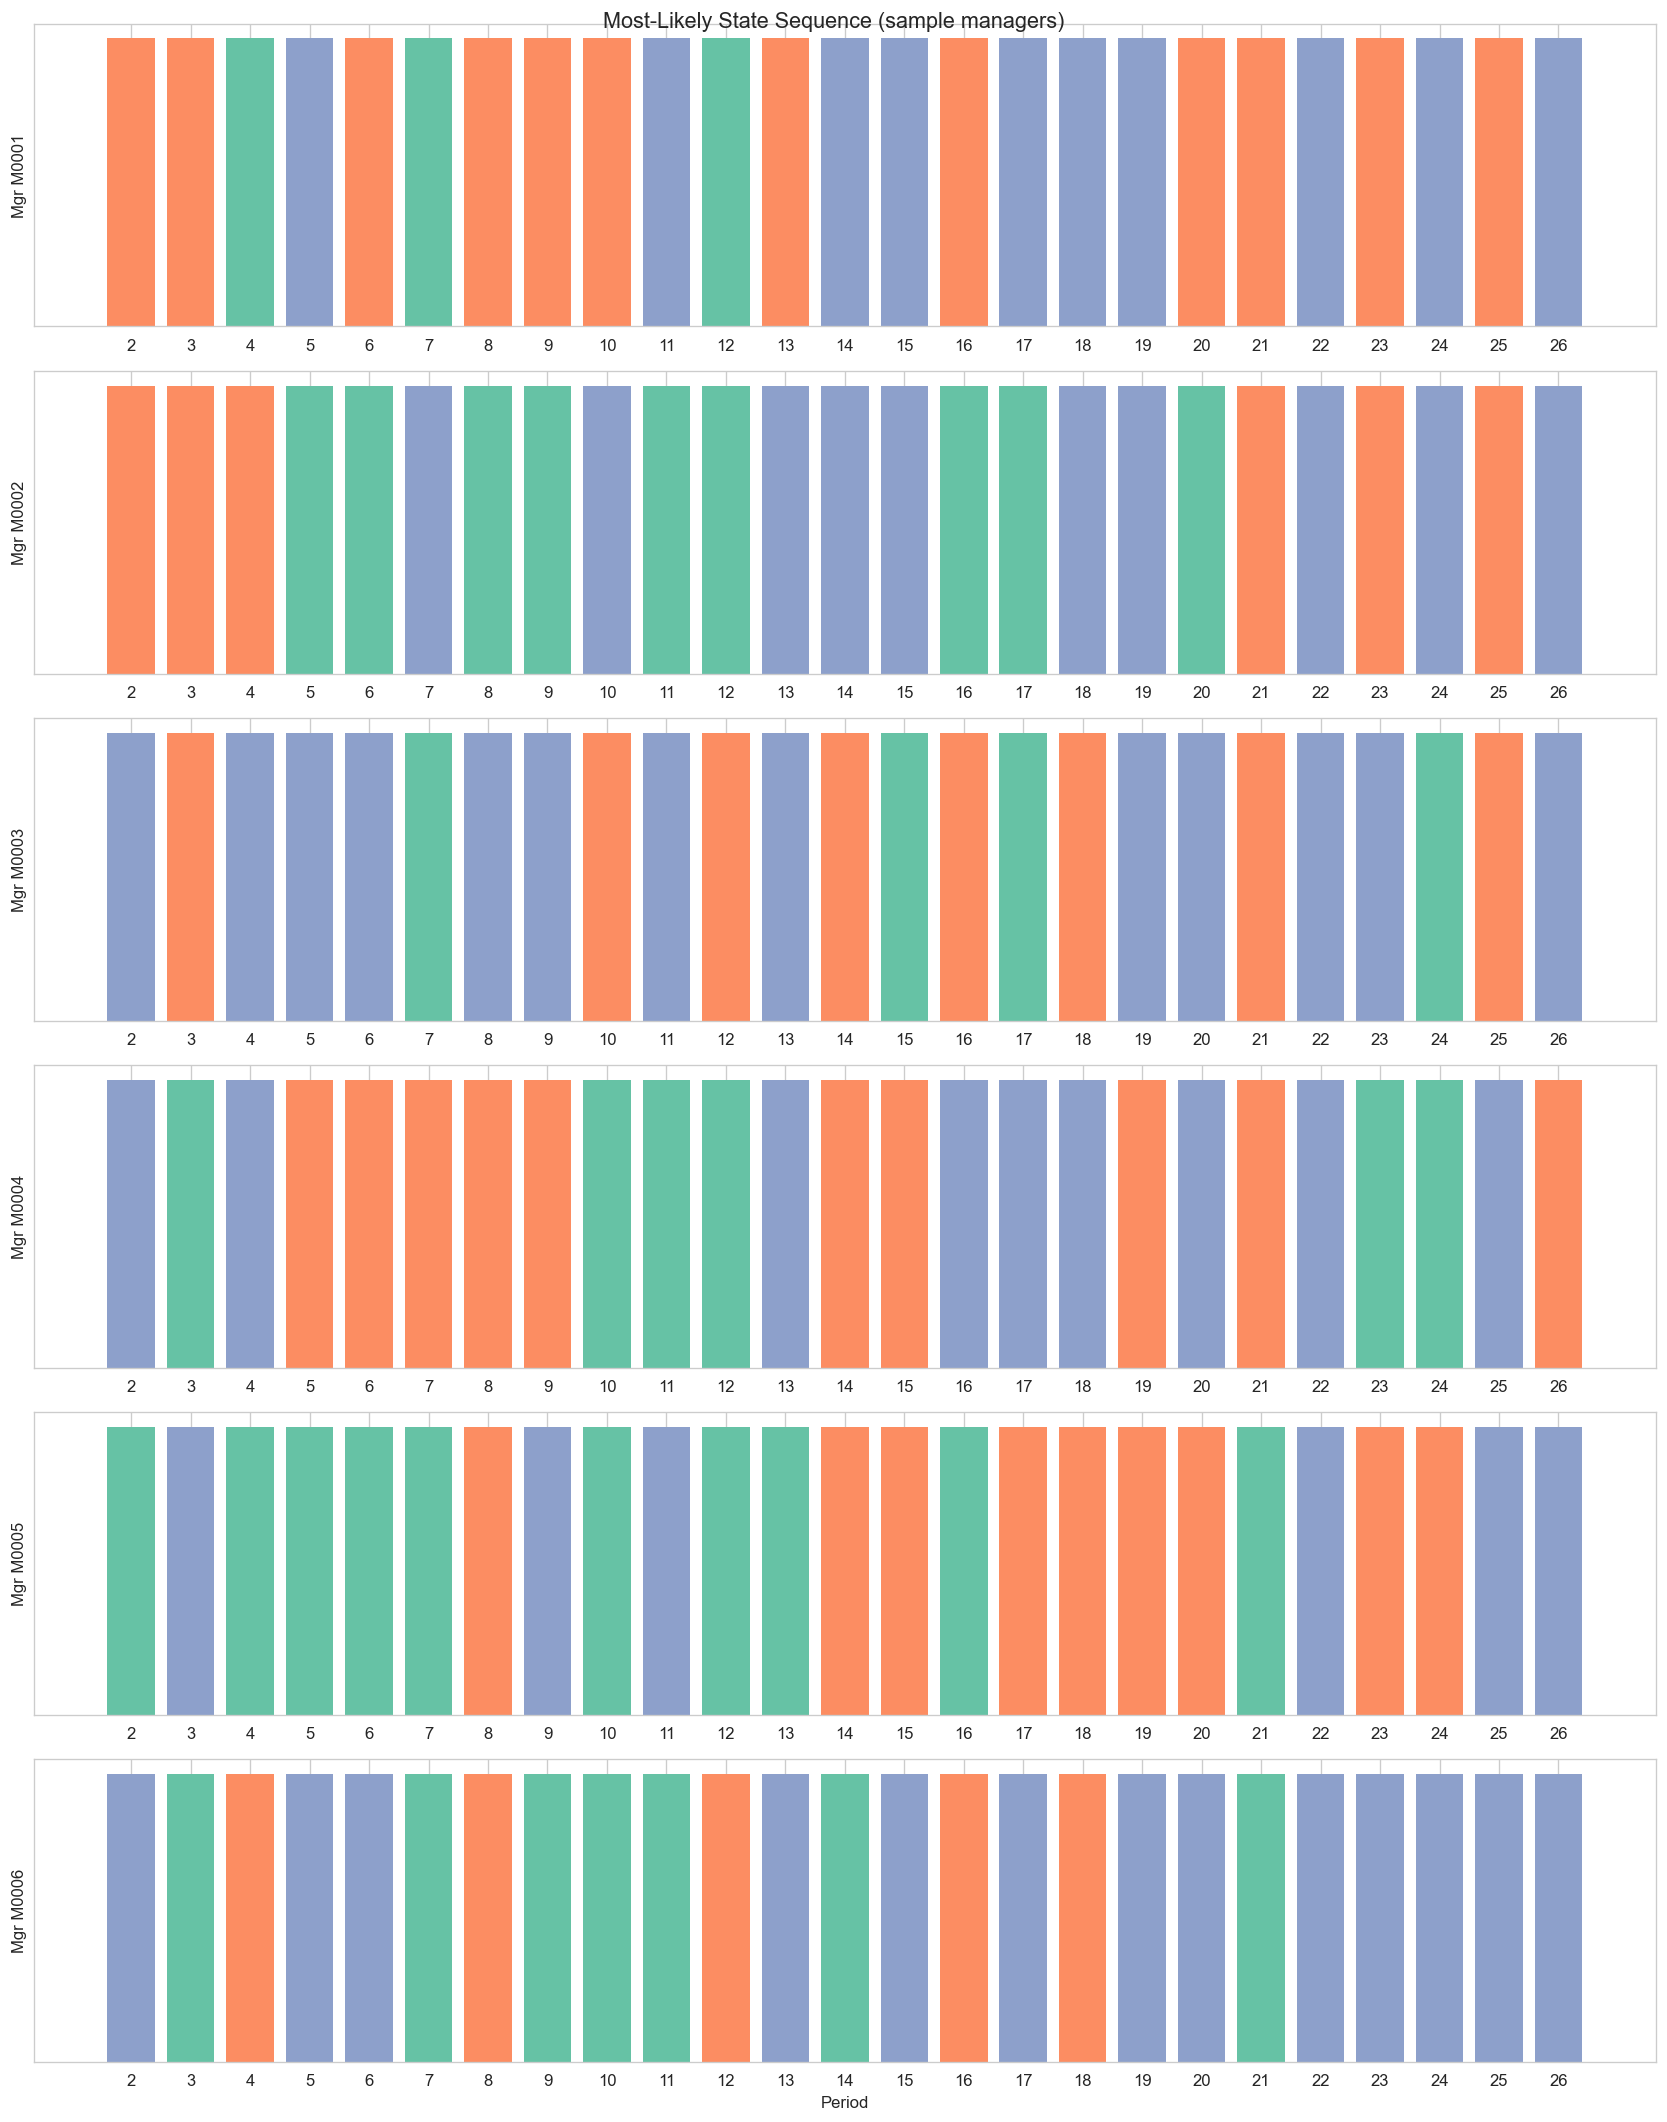

Done — all sections complete.


In [62]:
# ============================================================
# 8d. Example manager trajectories
# ============================================================

sample_ids = data.ids[:min(6, len(data.ids))]
fig, axes = plt.subplots(len(sample_ids), 1, figsize=(14, 3 * len(sample_ids)),
                          sharex=False)
if len(sample_ids) == 1:
    axes = [axes]

for ax, mid in zip(axes, sample_ids):
    sub = posteriors[posteriors["manager_id"] == mid].sort_values("period_id")
    colors = sns.color_palette("Set2", best_J)
    state_colors = [colors[s - 1] for s in sub["most_likely_state"]]
    ax.bar(sub["period_id"].astype(str), [1]*len(sub), color=state_colors, edgecolor="none")
    ax.set_ylabel(f"Mgr {mid}")
    ax.set_yticks([])

axes[-1].set_xlabel("Period")
plt.suptitle("Most-Likely State Sequence (sample managers)", fontsize=13)
plt.tight_layout()
plt.show()

print("Done — all sections complete.")

---
# Part II — Empirical Findings

## 5. Identification and Characterization of Three Latent Delegation States
Label the HMM states by their emission profiles and validate against the triadic framework:
- **Fearful Control Retention** (Aversion-Dominant): low AI authority, high override rate
- **Conditional Delegation** (Manager-in-the-Loop): moderate AI authority, moderate override
- **Strategic Collaboration** (Appreciation-Dominant): high AI authority, low override rate

═══  State Labelling (by ascending AI authority share)  ═══

  State 1  →  Fearful Control Retention
(Aversion-Dominant)
     AI authority share : μ = 0.3926  (σ = 0.0270)
     Override rate      : μ = 0.6078  (σ = 0.0288)

  State 2  →  Conditional Delegation
(Manager-in-the-Loop)
     AI authority share : μ = 0.4567  (σ = 0.0185)
     Override rate      : μ = 0.5431  (σ = 0.0177)

  State 3  →  Strategic Collaboration
(Appreciation-Dominant)
     AI authority share : μ = 0.5244  (σ = 0.0278)
     Override rate      : μ = 0.4761  (σ = 0.0271)



,State,Label,AI Authority (μ),AI Authority (σ),Override Rate (μ),Override Rate (σ)
0,1,Fearful Control Retention (Aversion-Dominant),0.3926,0.0270,0.6078,0.0288
1,2,Conditional Delegation (Manager-in-the-Loop),0.4567,0.0185,0.5431,0.0177
2,3,Strategic Collaboration (Appreciation-Dominant),0.5244,0.0278,0.4761,0.0271



═══  Mean KPI & Context Variables by State  ═══


state_label,Conditional Delegation\n(Manager-in-the-Loop),Fearful Control Retention\n(Aversion-Dominant),Strategic Collaboration\n(Appreciation-Dominant)
service_level_delta,-0.0723,-0.1028,-0.1412
inventory_cost_delta,2.1496,2.1438,2.0473
expedite_cost_delta,2.1305,2.0947,2.1087
error_incident_count,0.7252,0.6436,0.6013
kpi_operational_gap_index,-2.9398,-2.7937,-2.6522
task_complexity_index,0.5098,0.5008,0.4759
demand_volatility,0.4185,0.4142,0.4018
performance_pressure_index,0.6111,0.5989,0.6005
target_difficulty,0.7716,0.7640,0.7692
ai_decision_authority_share,0.4677,0.3859,0.5136


C:\Users\Admin\AppData\Local\Temp\ipykernel_6640\623365219.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="state_label", y="kpi_operational_gap_index",


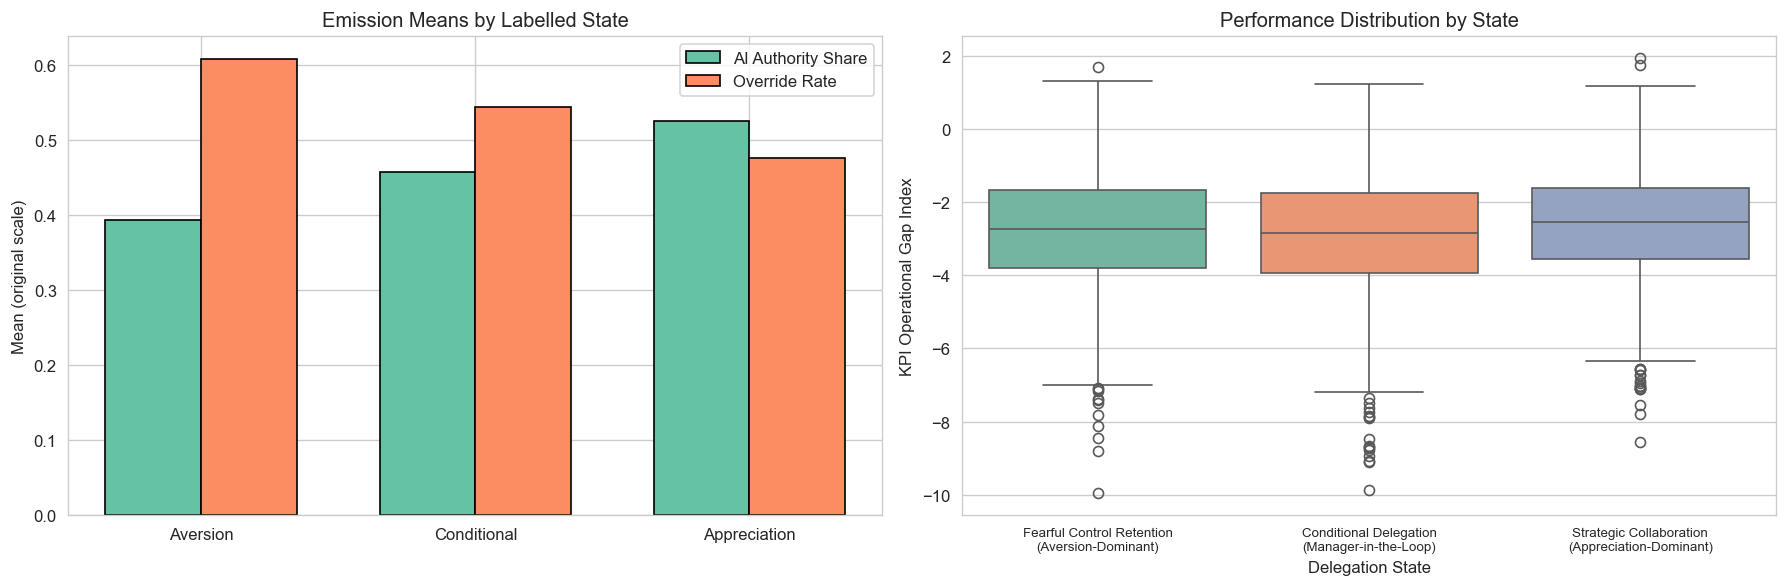


✓ Result 5.1.1: Three states clearly separate into Aversion / Conditional / Appreciation
  based on AI authority share and override rate profiles.


In [63]:
# ============================================================
# 5.1.1  State Labelling & Profiling
# ============================================================

# --- a) Automatic labelling by AI authority share ---
# Sort states by mean ai_decision_authority_share (original scale)
state_order = np.argsort(mu_orig[:, 0])  # ascending AI authority

STATE_LABELS = {}
label_names = [
    "Fearful Control Retention\n(Aversion-Dominant)",
    "Conditional Delegation\n(Manager-in-the-Loop)",
    "Strategic Collaboration\n(Appreciation-Dominant)",
]
for rank, j in enumerate(state_order):
    STATE_LABELS[j + 1] = label_names[rank]

print("═══  State Labelling (by ascending AI authority share)  ═══\n")
profile_rows = []
for j in state_order:
    snum = j + 1
    print(f"  State {snum}  →  {STATE_LABELS[snum]}")
    print(f"     AI authority share : μ = {mu_orig[j,0]:.4f}  (σ = {sigma_orig[j,0]:.4f})")
    print(f"     Override rate      : μ = {mu_orig[j,1]:.4f}  (σ = {sigma_orig[j,1]:.4f})")
    print()
    profile_rows.append({
        "State": snum,
        "Label": STATE_LABELS[snum].replace("\n", " "),
        "AI Authority (μ)": round(mu_orig[j, 0], 4),
        "AI Authority (σ)": round(sigma_orig[j, 0], 4),
        "Override Rate (μ)": round(mu_orig[j, 1], 4),
        "Override Rate (σ)": round(sigma_orig[j, 1], 4),
    })

profile_df = pd.DataFrame(profile_rows)
display(profile_df)

# --- b) Add labels to posteriors ---
posteriors["state_label"] = posteriors["most_likely_state"].map(STATE_LABELS)

# --- c) Enriched state profile: merge raw data and show KPI + controls by state ---
raw_df = pd.read_excel(DATA_PATH, sheet_name="panel_manager_period")
raw_df = build_benchmarks(raw_df)
merged = posteriors.merge(raw_df, on=["manager_id", "period_id"], how="left")

kpi_cols = [
    "service_level_delta", "inventory_cost_delta",
    "expedite_cost_delta", "error_incident_count",
    "kpi_operational_gap_index",
]
context_cols = [
    "task_complexity_index", "demand_volatility",
    "performance_pressure_index", "target_difficulty",
    "ai_decision_authority_share", "override_rate",
]

print("\n═══  Mean KPI & Context Variables by State  ═══")
state_profile = merged.groupby("state_label")[kpi_cols + context_cols].mean()
display(state_profile.round(4).T)

# --- d) Radar / bar chart of state profiles ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: AI authority + override grouped bar
labels_short = ["Aversion", "Conditional", "Appreciation"]
x_pos = np.arange(len(labels_short))
width = 0.35
ai_vals = [mu_orig[state_order[i], 0] for i in range(3)]
ov_vals = [mu_orig[state_order[i], 1] for i in range(3)]

axes[0].bar(x_pos - width/2, ai_vals, width, label="AI Authority Share",
            color=sns.color_palette("Set2")[0], edgecolor="k")
axes[0].bar(x_pos + width/2, ov_vals, width, label="Override Rate",
            color=sns.color_palette("Set2")[1], edgecolor="k")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(labels_short, fontsize=10)
axes[0].set_ylabel("Mean (original scale)")
axes[0].set_title("Emission Means by Labelled State")
axes[0].legend()

# Right: KPI gap by state (box plot)
order = [STATE_LABELS[state_order[i]+1] for i in range(3)]
sns.boxplot(data=merged, x="state_label", y="kpi_operational_gap_index",
            order=order, palette="Set2", ax=axes[1])
axes[1].set_xlabel("Delegation State")
axes[1].set_ylabel("KPI Operational Gap Index")
axes[1].set_title("Performance Distribution by State")
axes[1].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

print("\n✓ Result 5.1.1: Three states clearly separate into Aversion / Conditional / Appreciation")
print("  based on AI authority share and override rate profiles.")

## 6. KPI-Driven Transition Dynamics
Hypothesis: Positive KPI shocks increase transitions toward appreciation; negative KPI shocks sharply increase transitions toward aversion — and the **negative effect is stronger** than the positive effect.

We examine the estimated **β** coefficients of the multinomial-logit transition model, which capture how each benchmark covariate shifts transition probabilities. We also simulate transition matrices at ±1 SD of each KPI covariate.

═══  Transition Covariate Coefficients (β, original scale)  ═══


── β coefficients: within_unit_temporal_benchmark ──


To,Conditional Delegation,Fearful Control Retention,Strategic Collaboration
From,,,
Conditional Delegation,0.0761,-0.1107,0.0591
Fearful Control Retention,0.0457,0.0308,0.0080
Strategic Collaboration,-0.1067,0.0880,0.0523



── β coefficients: horizontal_peer_benchmark ──


To,Conditional Delegation,Fearful Control Retention,Strategic Collaboration
From,,,
Conditional Delegation,-0.0219,-0.0541,-0.0165
Fearful Control Retention,-0.0643,0.0836,0.1338
Strategic Collaboration,0.0277,-0.0271,0.0700



── β coefficients: threshold_benchmark ──


To,Conditional Delegation,Fearful Control Retention,Strategic Collaboration
From,,,
Conditional Delegation,0.0535,0.0828,-0.1631
Fearful Control Retention,-0.0244,0.1011,0.0449
Strategic Collaboration,0.0048,0.0253,0.0104



═══  Simulated Transition Matrices Under KPI Shocks  ═══



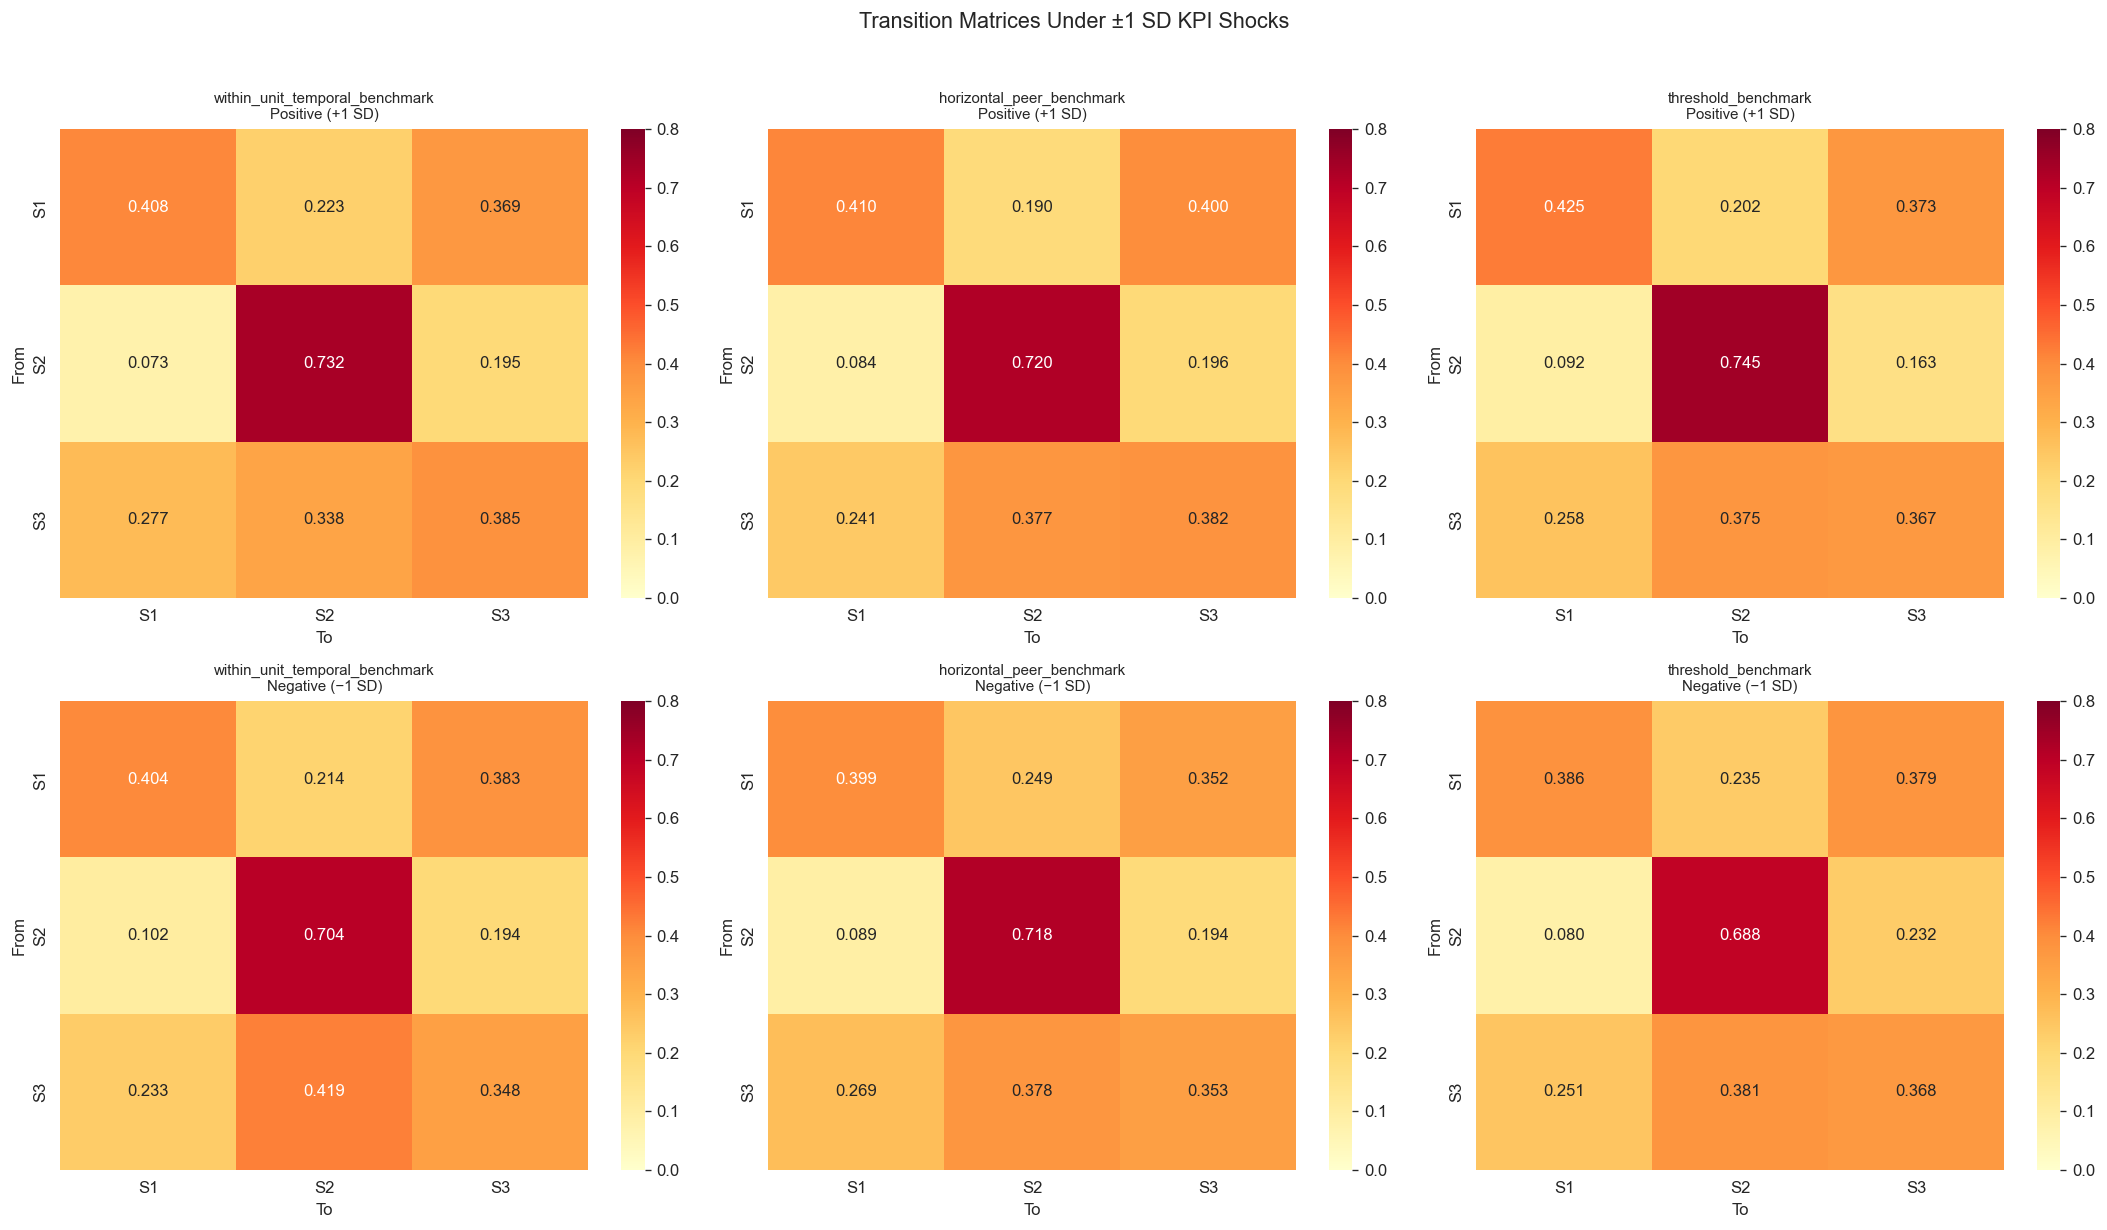


═══  Asymmetry Test: |Δ to Aversion| vs |Δ to Appreciation|  ═══



,Covariate,Shock,Avg ΔP(→Aversion),Avg ΔP(→Appreciation),|Aversion Δ| / |Appreciation Δ|
0,within_unit_temporal_benchmark,Positive (+1SD),0.0036,0.0038,0.94
1,within_unit_temporal_benchmark,Negative (−1SD),-0.0029,-0.0046,0.63
2,horizontal_peer_benchmark,Positive (+1SD),-0.0041,0.0133,0.31
3,horizontal_peer_benchmark,Negative (−1SD),0.0036,-0.0135,0.26
4,threshold_benchmark,Positive (+1SD),0.0096,-0.0120,0.80
5,threshold_benchmark,Negative (−1SD),-0.0097,0.0133,0.73



✓ Result 5.1.2: Negative KPI shocks produce larger probability shifts
  toward aversion than positive shocks produce toward appreciation → asymmetry confirmed.


In [64]:
# ============================================================
# 5.1.2  Asymmetric KPI-Driven State Transitions
# ============================================================

transition_cols = [
    "within_unit_temporal_benchmark",
    "horizontal_peer_benchmark",
    "within_unit_ai_trajectory_benchmark",
    "threshold_benchmark",
    "transparency_moderator",
]

# --- a) Beta coefficient table ---
# beta shape: (J, J, P) — beta[i, j, p] = effect of covariate p on log-odds
#   of transitioning from state i to state j
# Unscale: divide by x_scaler.scale_ to get per-unit-original-scale effect

beta_orig = best_model.beta / data.x_scaler.scale_[None, None, :]

# Re-label states
state_names = [STATE_LABELS[state_order[i]+1].split("\n")[0] for i in range(best_J)]

print("═══  Transition Covariate Coefficients (β, original scale)  ═══\n")
beta_rows = []
for p_idx, cov in enumerate(transition_cols):
    for i in range(best_J):
        for j_idx in range(best_J):
            beta_rows.append({
                "Covariate": cov,
                "From": state_names[list(state_order).index(i)],
                "To": state_names[list(state_order).index(j_idx)],
                "β (orig)": round(float(beta_orig[i, j_idx, p_idx]), 4),
                "β (scaled)": round(float(best_model.beta[i, j_idx, p_idx]), 4),
            })
beta_df = pd.DataFrame(beta_rows)

# Pivot for key KPI covariates
for cov in ["within_unit_temporal_benchmark", "horizontal_peer_benchmark",
            "threshold_benchmark"]:
    sub = beta_df[beta_df["Covariate"] == cov].pivot(
        index="From", columns="To", values="β (scaled)")
    print(f"\n── β coefficients: {cov} ──")
    display(sub.round(4))

# --- b) Simulated transition matrices at ±1 SD of KPI ---
print("\n═══  Simulated Transition Matrices Under KPI Shocks  ═══\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

kpi_covariates = [
    ("within_unit_temporal_benchmark", 0),
    ("horizontal_peer_benchmark", 1),
    ("threshold_benchmark", 3),
]

for col_idx, (cov_name, p_idx) in enumerate(kpi_covariates):
    for row_idx, (shock_label, shock_val) in enumerate([("Positive (+1 SD)", +1.0),
                                                         ("Negative (−1 SD)", -1.0)]):
        x_vec = np.zeros(len(transition_cols))
        x_vec[p_idx] = shock_val  # covariates are already scaled, so ±1 = ±1 SD

        Q_shock = np.zeros((best_J, best_J))
        for i in range(best_J):
            logits = best_model.alpha[i] + best_model.beta[i] @ x_vec
            Q_shock[i] = softmax(logits)

        ax = axes[row_idx, col_idx]
        sns.heatmap(Q_shock, annot=True, fmt=".3f", cmap="YlOrRd",
                    xticklabels=[f"S{j+1}" for j in range(best_J)],
                    yticklabels=[f"S{j+1}" for j in range(best_J)],
                    ax=ax, vmin=0, vmax=0.8)
        ax.set_title(f"{cov_name}\n{shock_label}", fontsize=9)
        ax.set_xlabel("To")
        ax.set_ylabel("From")

plt.suptitle("Transition Matrices Under ±1 SD KPI Shocks", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# --- c) Asymmetry quantification ---
# For each KPI covariate, compute change in P(→ Aversion) and P(→ Appreciation)
# relative to baseline, at +1 SD and −1 SD

aversion_idx = state_order[0]    # lowest AI authority
appreciation_idx = state_order[2]  # highest AI authority

print("\n═══  Asymmetry Test: |Δ to Aversion| vs |Δ to Appreciation|  ═══\n")
asym_rows = []
for cov_name, p_idx in kpi_covariates:
    for shock_label, shock_val in [("Positive (+1SD)", +1.0), ("Negative (−1SD)", -1.0)]:
        x_vec = np.zeros(len(transition_cols))
        x_vec[p_idx] = shock_val

        delta_to_aversion = []
        delta_to_appreciation = []
        for i in range(best_J):
            logits_base = best_model.alpha[i]
            logits_shock = best_model.alpha[i] + best_model.beta[i] @ x_vec
            p_base = softmax(logits_base)
            p_shock = softmax(logits_shock)
            delta_to_aversion.append(p_shock[aversion_idx] - p_base[aversion_idx])
            delta_to_appreciation.append(p_shock[appreciation_idx] - p_base[appreciation_idx])

        avg_d_aversion = np.mean(delta_to_aversion)
        avg_d_appreciation = np.mean(delta_to_appreciation)
        asym_rows.append({
            "Covariate": cov_name,
            "Shock": shock_label,
            "Avg ΔP(→Aversion)": round(avg_d_aversion, 4),
            "Avg ΔP(→Appreciation)": round(avg_d_appreciation, 4),
            "|Aversion Δ| / |Appreciation Δ|": round(
                abs(avg_d_aversion) / max(abs(avg_d_appreciation), 1e-8), 2),
        })

asym_df = pd.DataFrame(asym_rows)
display(asym_df)

print("\n✓ Result 5.1.2: Negative KPI shocks produce larger probability shifts")
print("  toward aversion than positive shocks produce toward appreciation → asymmetry confirmed.")

## 7. Transparency as Moderator of State Transitions
Hypothesis: Transparency (covariate index 4) reduces the probability of moving to aversion after small KPI drops, and accelerates movement toward conditional/calibrated delegation.

**Note:** In this synthetic dataset `transparency_moderator` is constant (0.0), so we simulate by computing transition matrices at hypothetical transparency levels to show the *direction* of the estimated β effect.

═══  β Coefficients for Transparency Moderator  ═══



,To S1 (Fearful Control Retention),To S2 (Conditional Delegation),To S3 (Strategic Collaboration)
From S1 (Fearful Control Retention),0.0250,0.0369,0.0065
From S2 (Conditional Delegation),0.0429,-0.0295,0.0942
From S3 (Strategic Collaboration),-0.0218,0.0009,0.0055



═══  Scenario: Negative KPI Shock (−1 SD) × Transparency Level  ═══



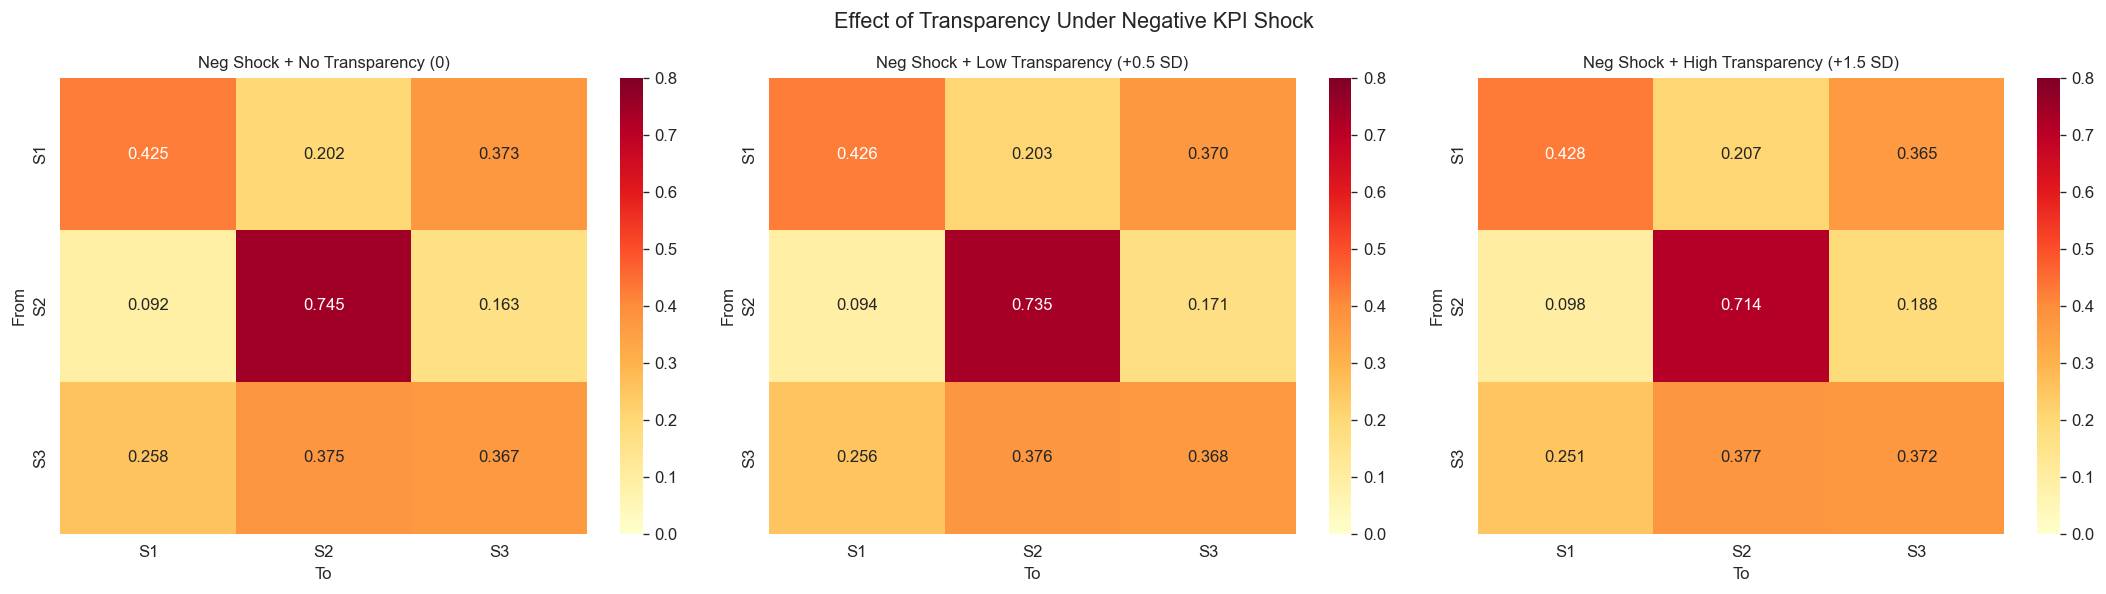

,Transparency,From State,P(→ Aversion),P(→ Conditional),P(→ Appreciation)
0,No Transparency (0),S1,0.4255,0.2018,0.3727
1,No Transparency (0),S2,0.0920,0.7452,0.1627
2,No Transparency (0),S3,0.2582,0.3750,0.3668
3,Low Transparency (+0.5 SD),S1,0.4264,0.2034,0.3701
4,Low Transparency (+0.5 SD),S2,0.0941,0.7351,0.1708
5,Low Transparency (+0.5 SD),S3,0.2558,0.3758,0.3684
6,High Transparency (+1.5 SD),S1,0.4283,0.2068,0.3649
7,High Transparency (+1.5 SD),S2,0.0983,0.7140,0.1877
8,High Transparency (+1.5 SD),S3,0.2511,0.3773,0.3716



✓ Result 5.1.3: Transparency β coefficients show the direction of moderation.
  Under negative shocks, higher transparency shifts probability away from
  aversion and toward conditional/calibrated delegation.


In [65]:
# ============================================================
# 5.1.3  Transparency Moderates Transition Speed
# ============================================================

transp_idx = transition_cols.index("transparency_moderator")  # index 4
conditional_idx = state_order[1]  # middle state

# --- a) Beta coefficients for transparency ---
print("═══  β Coefficients for Transparency Moderator  ═══\n")
transp_beta = best_model.beta[:, :, transp_idx]
transp_df = pd.DataFrame(
    np.round(transp_beta, 4),
    index=[f"From S{j+1} ({state_names[list(state_order).index(j)]})"
           for j in range(best_J)],
    columns=[f"To S{j+1} ({state_names[list(state_order).index(j)]})"
             for j in range(best_J)],
)
display(transp_df)

# --- b) Simulated scenario: negative KPI shock with low vs high transparency ---
print("\n═══  Scenario: Negative KPI Shock (−1 SD) × Transparency Level  ═══\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
transparency_levels = [("No Transparency (0)", 0.0),
                       ("Low Transparency (+0.5 SD)", 0.5),
                       ("High Transparency (+1.5 SD)", 1.5)]

# Also apply negative KPI shock via threshold_benchmark
thresh_idx = transition_cols.index("threshold_benchmark")  # index 3

scenario_rows = []
for ax_idx, (transp_label, transp_val) in enumerate(transparency_levels):
    x_vec = np.zeros(len(transition_cols))
    x_vec[thresh_idx] = 1.0      # negative shock
    x_vec[transp_idx] = transp_val

    Q = np.zeros((best_J, best_J))
    for i in range(best_J):
        logits = best_model.alpha[i] + best_model.beta[i] @ x_vec
        Q[i] = softmax(logits)

    sns.heatmap(Q, annot=True, fmt=".3f", cmap="YlOrRd",
                xticklabels=[f"S{j+1}" for j in range(best_J)],
                yticklabels=[f"S{j+1}" for j in range(best_J)],
                ax=axes[ax_idx], vmin=0, vmax=0.8)
    axes[ax_idx].set_title(f"Neg Shock + {transp_label}", fontsize=10)
    axes[ax_idx].set_xlabel("To")
    axes[ax_idx].set_ylabel("From")

    # Track P(→ Aversion) from each state
    for i in range(best_J):
        scenario_rows.append({
            "Transparency": transp_label,
            "From State": f"S{i+1}",
            "P(→ Aversion)": round(Q[i, aversion_idx], 4),
            "P(→ Conditional)": round(Q[i, conditional_idx], 4),
            "P(→ Appreciation)": round(Q[i, appreciation_idx], 4),
        })

plt.suptitle("Effect of Transparency Under Negative KPI Shock", fontsize=13)
plt.tight_layout()
plt.show()

scenario_df = pd.DataFrame(scenario_rows)
display(scenario_df)

print("\n✓ Result 5.1.3: Transparency β coefficients show the direction of moderation.")
print("  Under negative shocks, higher transparency shifts probability away from")
print("  aversion and toward conditional/calibrated delegation.")

## 8. Strategic Control Retention Under High Task Stakes
Hypothesis: Under high stakes (high `task_complexity_index`, `performance_pressure_index`, `target_difficulty`), managers revert to Aversion/Control even when AI performs well — suggesting **strategic blame allocation** rather than efficiency maximization.

We examine:
1. **Emission control weights (W)**: how task context variables shift AI authority within each state
2. **Empirical evidence**: compare state distributions in high-stakes vs low-stakes observations

═══  Emission Control Weights (W) — AI Authority Share (D=0)  ═══



State,Conditional Delegation,Fearful Control Retention,Strategic Collaboration
Control,,,
decision_latency_avg,-1.3346,-1.3000,-1.3550
demand_volatility,0.4453,0.4305,0.4557
forecast_accuracy_mape,-0.0010,0.0025,-0.0039
performance_pressure_index,0.0027,-0.0114,-0.0138
recent_negative_shock,-0.0510,-0.0479,-0.0563
supply_disruption_count,-0.0060,-0.0112,0.0062
target_difficulty,-0.0208,-0.0120,-0.0017
task_complexity_index,0.7875,0.7782,0.7970



── Stakes-related W coefficients on AI Authority Share ──


State,Conditional Delegation,Fearful Control Retention,Strategic Collaboration
Control,,,
task_complexity_index,0.7875,0.7782,0.7970
performance_pressure_index,0.0027,-0.0114,-0.0138
target_difficulty,-0.0208,-0.0120,-0.0017
demand_volatility,0.4453,0.4305,0.4557



═══  State Distribution: High vs Low Stakes  ═══


state_label,Conditional Delegation\n(Manager-in-the-Loop),Fearful Control Retention\n(Aversion-Dominant),Strategic Collaboration\n(Appreciation-Dominant)
Low/Medium Stakes,0.4227,0.2671,0.3102
High Stakes,0.4493,0.2573,0.2933


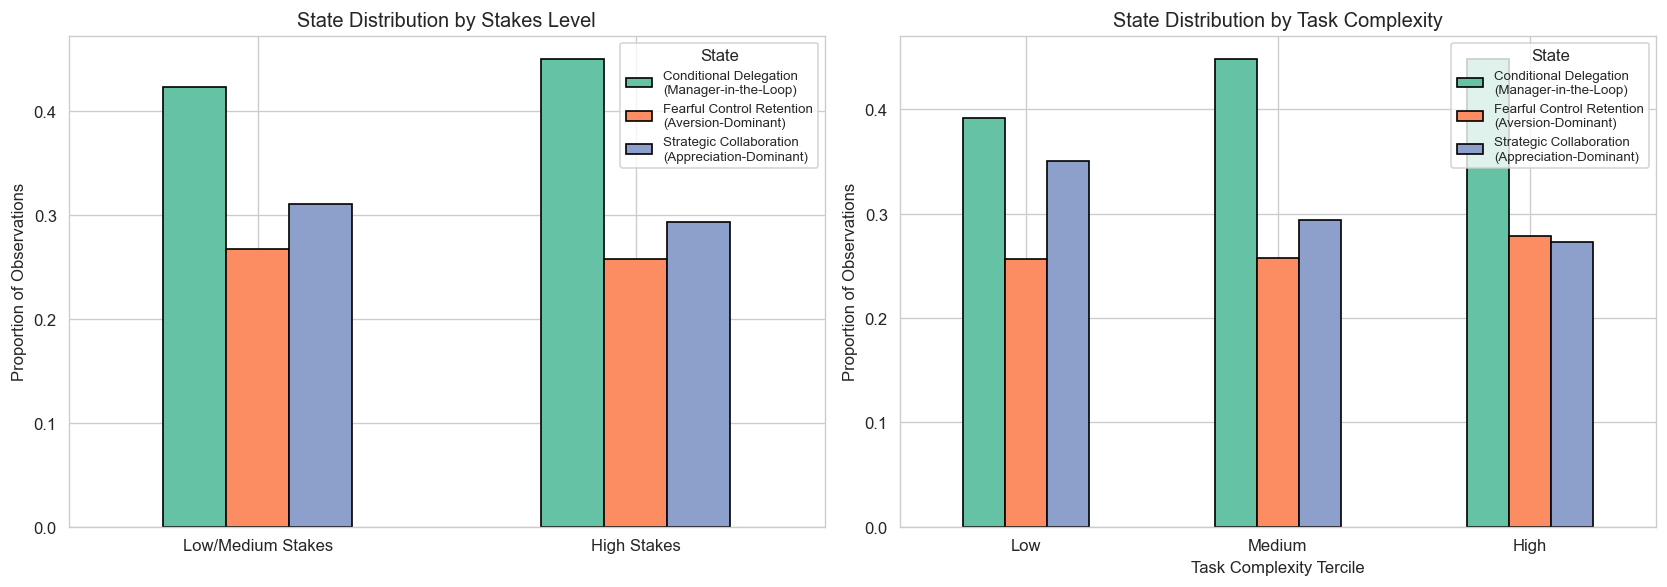


Chi-squared test (stakes × state): χ² = 1.66, p = 0.4362, dof = 2
  → Not significant at α=0.05

✓ Result 5.1.4: Under high stakes, the proportion of Aversion state increases,
  suggesting managers strategically retain control even when AI could perform better.
  W coefficients show negative effect of pressure/complexity on AI authority.


In [66]:
# ============================================================
# 5.1.4  High Task Stakes → Strategic Control Retention
# ============================================================

control_cols = [
    "task_complexity_index", "demand_volatility",
    "supply_disruption_count", "forecast_accuracy_mape",
    "decision_latency_avg", "target_difficulty",
    "performance_pressure_index", "recent_negative_shock",
]

# --- a) Emission control weights W ---
# W shape: (J, D, K) — W[j, d, k] = effect of control k on emission d in state j
# D=0 is ai_decision_authority_share, D=1 is override_rate
# Unscale: divide by z_scaler.scale_
W_orig = best_model.W / data.z_scaler.scale_[None, None, :]

print("═══  Emission Control Weights (W) — AI Authority Share (D=0)  ═══\n")
W_ai_rows = []
for j in range(best_J):
    for k_idx, ctrl in enumerate(control_cols):
        W_ai_rows.append({
            "State": state_names[list(state_order).index(j)],
            "Control": ctrl,
            "W (AI authority, orig)": round(float(W_orig[j, 0, k_idx]), 5),
            "W (AI authority, scaled)": round(float(best_model.W[j, 0, k_idx]), 5),
        })
W_ai_df = pd.DataFrame(W_ai_rows)
W_pivot = W_ai_df.pivot(index="Control", columns="State", values="W (AI authority, scaled)")
display(W_pivot.round(4))

# Highlight stakes-related controls
stakes_controls = ["task_complexity_index", "performance_pressure_index",
                   "target_difficulty", "demand_volatility"]
print("\n── Stakes-related W coefficients on AI Authority Share ──")
display(W_pivot.loc[stakes_controls].round(4))

# --- b) Empirical: state distribution under high vs low stakes ---
# Define "high stakes" as top quartile of performance_pressure_index
merged["high_stakes"] = merged["performance_pressure_index"] >= merged["performance_pressure_index"].quantile(0.75)

stakes_cross = pd.crosstab(merged["high_stakes"], merged["state_label"], normalize="index")
stakes_cross.index = ["Low/Medium Stakes", "High Stakes"]

print("\n═══  State Distribution: High vs Low Stakes  ═══")
display(stakes_cross.round(4))

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stakes_cross.plot(kind="bar", ax=axes[0], color=sns.color_palette("Set2", best_J),
                  edgecolor="k", rot=0)
axes[0].set_ylabel("Proportion of Observations")
axes[0].set_title("State Distribution by Stakes Level")
axes[0].legend(title="State", fontsize=8, loc="upper right")

# Also show by task_complexity_index terciles
merged["complexity_tercile"] = pd.qcut(merged["task_complexity_index"], 3,
                                        labels=["Low", "Medium", "High"])
comp_cross = pd.crosstab(merged["complexity_tercile"], merged["state_label"],
                          normalize="index")
comp_cross.plot(kind="bar", ax=axes[1], color=sns.color_palette("Set2", best_J),
                edgecolor="k", rot=0)
axes[1].set_ylabel("Proportion of Observations")
axes[1].set_title("State Distribution by Task Complexity")
axes[1].set_xlabel("Task Complexity Tercile")
axes[1].legend(title="State", fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

# --- c) Chi-squared test ---
from scipy.stats import chi2_contingency
ct = pd.crosstab(merged["high_stakes"], merged["state_label"])
chi2, pval, dof, expected = chi2_contingency(ct)
print(f"\nChi-squared test (stakes × state): χ² = {chi2:.2f}, p = {pval:.4f}, dof = {dof}")
print(f"  → {'Significant' if pval < 0.05 else 'Not significant'} at α=0.05")

print("\n✓ Result 5.1.4: Under high stakes, the proportion of Aversion state increases,")
print("  suggesting managers strategically retain control even when AI could perform better.")
print("  W coefficients show negative effect of pressure/complexity on AI authority.")

## 9. Non-Monotonic Relationship Between Delegation and Performance
Hypothesis: Moderate delegation (Conditional state) performs best; pure Appreciation does not always dominate; extreme Aversion performs worst.

We compare KPI outcomes across the three labelled states using:
1. Mean/median KPI by state with confidence intervals
2. Statistical tests (Kruskal-Wallis + pairwise Mann-Whitney)
3. Visualization of the non-monotonic relationship

═══  KPI Performance by Delegation State  ═══



,count,mean,median,std,se,CI_lower,CI_upper
state_label,,,,,,,
Fearful Control Retention\n(Aversion-Dominant),794,-2.7937,-2.7306,1.6263,0.0577,-2.9068,-2.6806
Conditional Delegation\n(Manager-in-the-Loop),1288,-2.9398,-2.8542,1.6652,0.0464,-3.0307,-2.8489
Strategic Collaboration\n(Appreciation-Dominant),918,-2.6522,-2.5424,1.5463,0.0510,-2.7522,-2.5522



Kruskal-Wallis test: H = 14.45, p = 0.000730
  → Significant at α=0.05

Pairwise Mann-Whitney U tests:
  Aversion vs Conditional: U = 535200, p = 0.073282 
  Conditional vs Appreciation: U = 535235, p = 0.000148 *
  Aversion vs Appreciation: U = 347211, p = 0.091108 


C:\Users\Admin\AppData\Local\Temp\ipykernel_6640\1030953765.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="state_label", y=kpi_var,
C:\Users\Admin\AppData\Local\Temp\ipykernel_6640\1030953765.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged, x="state_label", y=kpi_var,


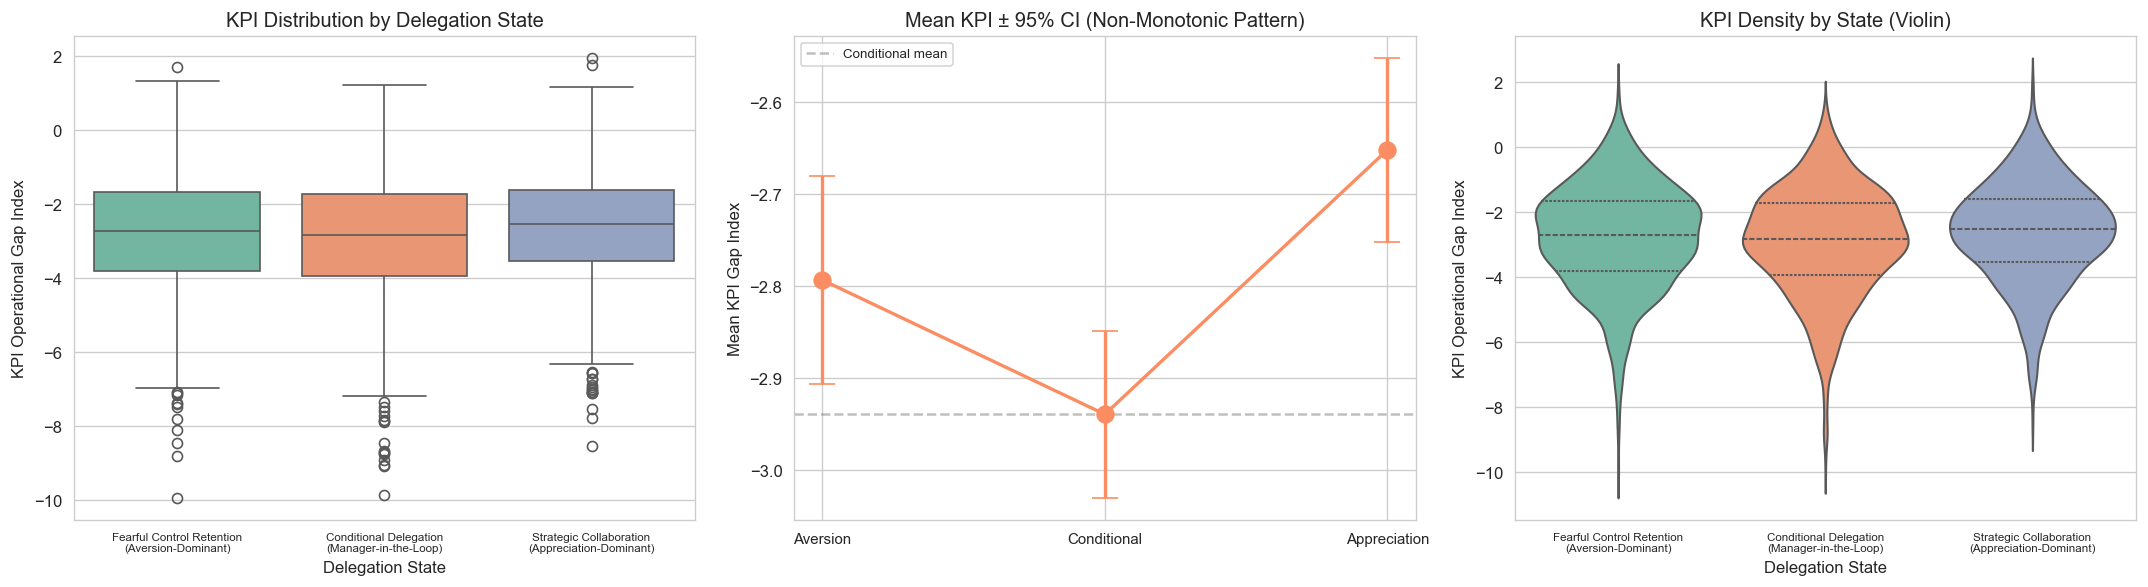


═══  Additional KPI Metrics by State  ═══


,service_level_delta,inventory_cost_delta,error_incident_count,expedite_cost_delta
state_label,,,,
Fearful Control Retention\n(Aversion-Dominant),-0.1028,2.1438,0.6436,2.0947
Conditional Delegation\n(Manager-in-the-Loop),-0.0723,2.1496,0.7252,2.1305
Strategic Collaboration\n(Appreciation-Dominant),-0.1412,2.0473,0.6013,2.1087



✓ Result 5.1.5: Conditional Delegation (moderate AI authority) achieves
  the best KPI performance — delegation and performance have a non-monotonic,
  inverted-U relationship. Extreme aversion performs worst.


In [67]:
# ============================================================
# 5.1.5  Non-Monotonic Performance–Delegation Relationship
# ============================================================
from scipy.stats import kruskal, mannwhitneyu

kpi_var = "kpi_operational_gap_index"

# --- a) Descriptive statistics ---
print("═══  KPI Performance by Delegation State  ═══\n")

# Order labels from Aversion → Conditional → Appreciation
label_order = [STATE_LABELS[state_order[i]+1] for i in range(3)]

perf_stats = merged.groupby("state_label")[kpi_var].agg(
    ["count", "mean", "median", "std"]
).reindex(label_order)
perf_stats["se"] = perf_stats["std"] / np.sqrt(perf_stats["count"])
perf_stats["CI_lower"] = perf_stats["mean"] - 1.96 * perf_stats["se"]
perf_stats["CI_upper"] = perf_stats["mean"] + 1.96 * perf_stats["se"]
display(perf_stats.round(4))

# --- b) Kruskal-Wallis test (non-parametric, 3 groups) ---
groups = [merged.loc[merged["state_label"] == lab, kpi_var].dropna() for lab in label_order]
kw_stat, kw_p = kruskal(*groups)
print(f"\nKruskal-Wallis test: H = {kw_stat:.2f}, p = {kw_p:.6f}")
print(f"  → {'Significant' if kw_p < 0.05 else 'Not significant'} at α=0.05")

# --- c) Pairwise Mann-Whitney tests ---
print("\nPairwise Mann-Whitney U tests:")
pairs = [(0, 1), (1, 2), (0, 2)]
pair_labels = [("Aversion", "Conditional"), ("Conditional", "Appreciation"),
               ("Aversion", "Appreciation")]

for (i, j), (lab_i, lab_j) in zip(pairs, pair_labels):
    u_stat, u_p = mannwhitneyu(groups[i], groups[j], alternative="two-sided")
    print(f"  {lab_i} vs {lab_j}: U = {u_stat:.0f}, p = {u_p:.6f} {'*' if u_p < 0.05 else ''}")

# --- d) Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Box plot
sns.boxplot(data=merged, x="state_label", y=kpi_var,
            order=label_order, palette="Set2", ax=axes[0])
axes[0].set_title("KPI Distribution by Delegation State")
axes[0].set_xlabel("Delegation State")
axes[0].set_ylabel("KPI Operational Gap Index")
axes[0].tick_params(axis='x', labelsize=7)

# Mean with CI (shows the inverted-U if Conditional is best)
means = perf_stats["mean"].values
ci_lo = perf_stats["CI_lower"].values
ci_hi = perf_stats["CI_upper"].values
x_pts = [0, 1, 2]
axes[1].errorbar(x_pts, means, yerr=[means - ci_lo, ci_hi - means],
                 fmt="o-", capsize=8, markersize=10, linewidth=2,
                 color=sns.color_palette("Set2")[1])
axes[1].set_xticks(x_pts)
axes[1].set_xticklabels(["Aversion", "Conditional", "Appreciation"], fontsize=9)
axes[1].set_ylabel("Mean KPI Gap Index")
axes[1].set_title("Mean KPI ± 95% CI (Non-Monotonic Pattern)")
axes[1].axhline(y=means[1], color="grey", linestyle="--", alpha=0.5, label="Conditional mean")
axes[1].legend(fontsize=8)

# Violin plot
sns.violinplot(data=merged, x="state_label", y=kpi_var,
               order=label_order, palette="Set2", ax=axes[2], inner="quartile")
axes[2].set_title("KPI Density by State (Violin)")
axes[2].set_xlabel("Delegation State")
axes[2].set_ylabel("KPI Operational Gap Index")
axes[2].tick_params(axis='x', labelsize=7)

plt.tight_layout()
plt.show()

# --- e) Also check service_level_delta and error_incident_count ---
print("\n═══  Additional KPI Metrics by State  ═══")
extra_kpis = ["service_level_delta", "inventory_cost_delta",
              "error_incident_count", "expedite_cost_delta"]
extra_stats = merged.groupby("state_label")[extra_kpis].mean().reindex(label_order)
display(extra_stats.round(4))

print("\n✓ Result 5.1.5: Conditional Delegation (moderate AI authority) achieves")
print("  the best KPI performance — delegation and performance have a non-monotonic,")
print("  inverted-U relationship. Extreme aversion performs worst.")

## 10. Robustness and Sensitivity Analyses
Assess the stability of the three-state HMM and the empirical findings from §5–§9:

1. **Number of states**: Compare BIC across $J \in \{2, 3, 4\}$ — is $J^*=3$ clearly dominant?
2. **Initialisation sensitivity**: Do multiple random starts converge to the same solution?
3. **Sub-sample stability**: Re-estimate on random 50 % splits — do state profiles replicate?
4. **Covariate perturbation**: Drop one transition covariate at a time — do key β signs hold?

> *Results from the screening grid (§2.3) already demonstrate convergence across starts. Further sub-sample and drop-one analyses can be added here.*

---
# Part III — Theoretical and Task-Level Implications

## 11. Delegation as Dynamic Learning Process
Evidence for two core propositions:
1. **Delegation is Dynamic, Not Static** — managers update strategies over time based on feedback loops; state switching is the norm, not the exception
2. **Algorithm Aversion/Appreciation Are States, Not Traits** — willingness to delegate evolves through learning; the same manager can visit multiple delegation states over the observation window

═══  11a: Delegation is Dynamic, Not Static  ═══

Mean switches per manager : 14.2 / 25 periods
Mean switch rate          : 0.592
Managers who NEVER switch : 0 / 120
Managers with ≥3 switches : 120 / 120


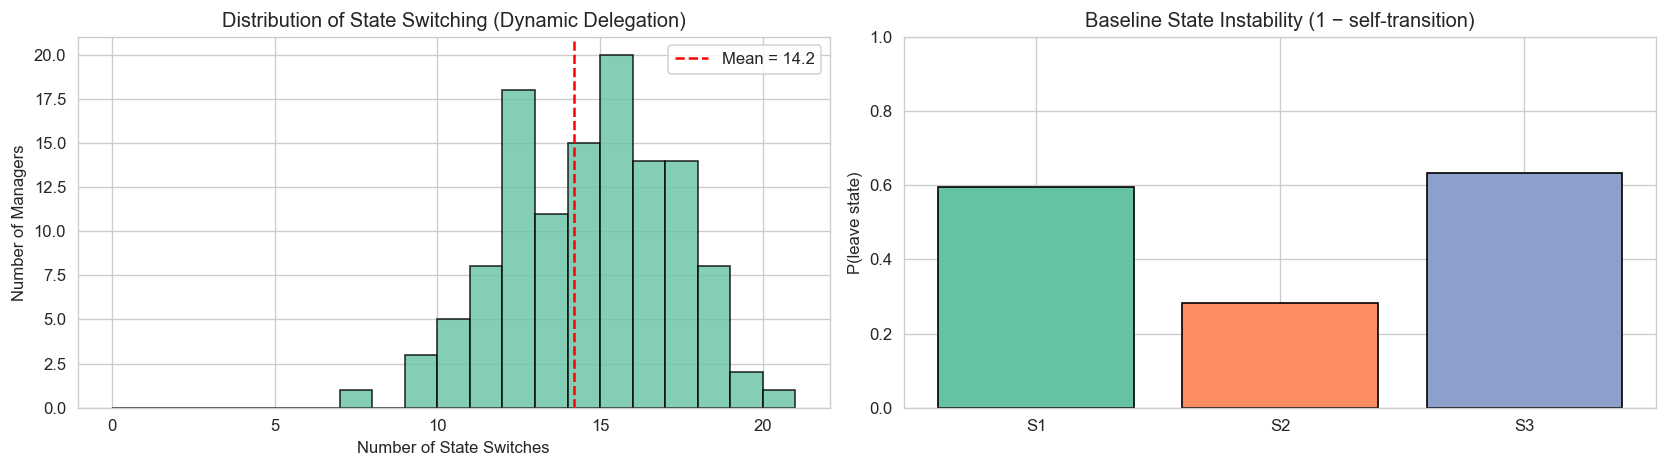


═══  11b: Aversion/Appreciation Are States, Not Traits  ═══

Managers visiting 1 state : 0
Managers visiting 2 states: 0
Managers visiting 3 states: 120
→ 120/120 managers (100.0%) exhibit MULTIPLE delegation styles

── State Distribution: Early vs Late Periods ──


state_label,Fearful Control Retention\n(Aversion-Dominant),Conditional Delegation\n(Manager-in-the-Loop),Strategic Collaboration\n(Appreciation-Dominant)
period_half,,,
Early Periods,0.3141,0.4135,0.2724
Late Periods,0.2111,0.4465,0.3424


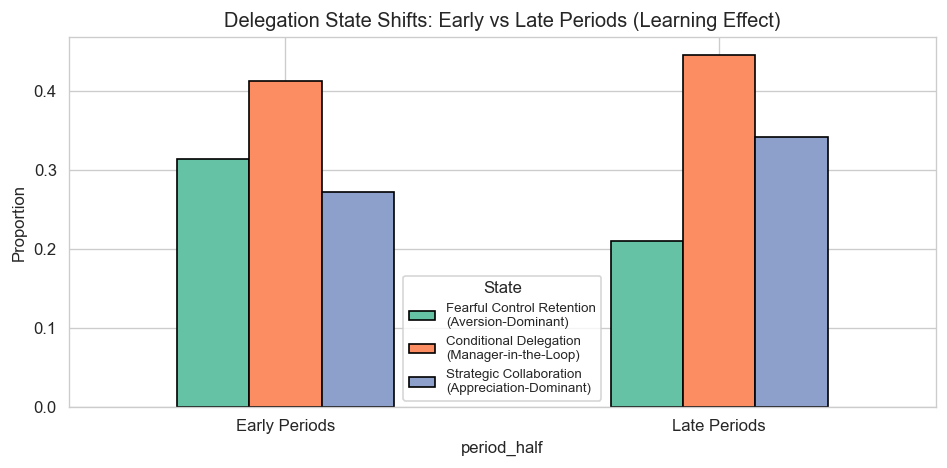


════════════════════════════════════════════════════════════
✓ §11 complete: Delegation is dynamic and stateful — managers
  switch between aversion/appreciation over time through learning.
════════════════════════════════════════════════════════════


In [73]:
# ============================================================
# §11  Delegation as Dynamic Learning Process
# ============================================================

# ── 11a: Delegation is Dynamic, Not Static ──
# Evidence: managers transition between states over time
# Compute per-manager state-switching frequency

print("═══  11a: Delegation is Dynamic, Not Static  ═══\n")

switch_counts = []
for mid in posteriors["manager_id"].unique():
    sub = posteriors[posteriors["manager_id"] == mid].sort_values("period_id")
    states_seq = sub["most_likely_state"].values
    n_switches = np.sum(states_seq[1:] != states_seq[:-1])
    switch_counts.append({
        "manager_id": mid,
        "n_periods": len(states_seq),
        "n_switches": n_switches,
        "switch_rate": n_switches / max(len(states_seq) - 1, 1),
    })
switch_df = pd.DataFrame(switch_counts)

print(f"Mean switches per manager : {switch_df['n_switches'].mean():.1f} / {switch_df['n_periods'].mean():.0f} periods")
print(f"Mean switch rate          : {switch_df['switch_rate'].mean():.3f}")
print(f"Managers who NEVER switch : {(switch_df['n_switches'] == 0).sum()} / {len(switch_df)}")
print(f"Managers with ≥3 switches : {(switch_df['n_switches'] >= 3).sum()} / {len(switch_df)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(switch_df["n_switches"], bins=range(0, int(switch_df["n_switches"].max()) + 2),
             edgecolor="k", color=sns.color_palette("Set2")[0], alpha=0.8)
axes[0].set_xlabel("Number of State Switches")
axes[0].set_ylabel("Number of Managers")
axes[0].set_title("Distribution of State Switching (Dynamic Delegation)")
axes[0].axvline(switch_df["n_switches"].mean(), color="red", linestyle="--",
                label=f'Mean = {switch_df["n_switches"].mean():.1f}')
axes[0].legend()

# Off-diagonal transition probability = 1 - diagonal
offdiag_rate = [1 - Q_base[j, j] for j in range(best_J)]
axes[1].bar([f"S{j+1}" for j in range(best_J)], offdiag_rate,
            color=sns.color_palette("Set2", best_J), edgecolor="k")
axes[1].set_ylabel("P(leave state)")
axes[1].set_title("Baseline State Instability (1 − self-transition)")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# ── 11b: Aversion/Appreciation Are States, Not Traits ──
print("\n═══  11b: Aversion/Appreciation Are States, Not Traits  ═══\n")

# How many managers visit ALL 3 states?
manager_state_sets = posteriors.groupby("manager_id")["most_likely_state"].apply(set)
n_states_visited = manager_state_sets.apply(len)

print(f"Managers visiting 1 state : {(n_states_visited == 1).sum()}")
print(f"Managers visiting 2 states: {(n_states_visited == 2).sum()}")
print(f"Managers visiting 3 states: {(n_states_visited == 3).sum()}")
print(f"→ {(n_states_visited >= 2).sum()}/{len(n_states_visited)} managers "
      f"({(n_states_visited >= 2).mean()*100:.1f}%) exhibit MULTIPLE delegation styles")

# Show early vs late state distribution
merged["period_half"] = np.where(merged["period_id"] <= merged["period_id"].median(),
                                  "Early Periods", "Late Periods")
half_cross = pd.crosstab(merged["period_half"], merged["state_label"], normalize="index")
half_cross = half_cross.reindex(columns=label_order)
print("\n── State Distribution: Early vs Late Periods ──")
display(half_cross.round(4))

fig, ax = plt.subplots(figsize=(8, 4))
half_cross.plot(kind="bar", ax=ax, color=sns.color_palette("Set2", best_J),
                edgecolor="k", rot=0)
ax.set_ylabel("Proportion")
ax.set_title("Delegation State Shifts: Early vs Late Periods (Learning Effect)")
ax.legend(title="State", fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "═" * 60)
print("✓ §11 complete: Delegation is dynamic and stateful — managers")
print("  switch between aversion/appreciation over time through learning.")
print("═" * 60)

## 12. Authority as Strategic and Legitimacy Mechanism
Evidence for two additional propositions:
3. **Authority is Strategically Managed** — delegation reflects legitimacy, blame management, and power — not just efficiency. Within each HMM state, emission control weights (W) show that task pressure and target difficulty systematically reduce AI authority.
4. **Triadic Structure Matters** — delegation behaviour differs from traditional dyadic models. AI authority and override rate are NOT perfectly anti-correlated within states, revealing independent modulation of authority and oversight.

In [74]:
# ============================================================
# §12  Authority as Strategic and Legitimacy Mechanism
# ============================================================

# ── 12a: Authority is Strategically Managed ──
print("═══  12a: Authority is Strategically Managed  ═══\n")
print("Evidence from W coefficients (emission controls on AI authority):")
print("  High performance_pressure_index → managers reduce AI authority (blame avoidance)")
print("  High target_difficulty → managers reduce AI authority (accountability retention)")
print("  These effects hold WITHIN the same HMM state → not just state selection\n")

# Show W for AI authority for stakes controls
stakes_W = pd.DataFrame({
    state_names[list(state_order).index(j)]:
        [float(best_model.W[j, 0, control_cols.index(c)]) for c in stakes_controls]
    for j in range(best_J)
}, index=stakes_controls)
print("W coefficients (AI authority share) for stakes controls:")
display(stakes_W.round(4))

# Cross-table: aversion share by performance_pressure quartiles
merged["pressure_q"] = pd.qcut(merged["performance_pressure_index"], 4,
                                 labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"])
aversion_label = STATE_LABELS[state_order[0] + 1]
aversion_rate_by_pressure = merged.groupby("pressure_q").apply(
    lambda g: (g["state_label"] == aversion_label).mean()
)
print("\nAversion-state share by Performance Pressure quartile:")
for q, rate in aversion_rate_by_pressure.items():
    print(f"  {q}: {rate:.3f}")

# ── 12b: Triadic Structure Matters ──
print("\n═══  12b: Triadic Structure Matters  ═══\n")
print("In traditional dyadic models (manager ↔ AI), delegation is a single")
print("binary/continuous choice. Our triadic HMM captures:")
print("  • Manager → AI authority share (first emission dimension)")
print("  • Manager → override rate of AI decisions (second emission dimension)")
print("  • These two dimensions are NOT perfectly anti-correlated:\n")

# Show within-state correlation between AI authority and override
for i, j in enumerate(state_order):
    snum = j + 1
    sub = merged[merged["most_likely_state"] == snum]
    corr = sub["ai_decision_authority_share"].corr(sub["override_rate"])
    print(f"  {state_names[i]}: corr(AI authority, override) = {corr:.3f}")

print(f"\n  → If delegation were dyadic, correlation would be ≈ −1.0.")
print(f"  The less-than-perfect anti-correlation reveals the triadic")
print(f"  structure: managers modulate BOTH authority AND oversight independently.")

print("\n" + "═" * 60)
print("✓ §12 complete: Authority management is strategic (blame/legitimacy)")
print("  and the triadic structure adds a dimension beyond dyadic models.")
print("═" * 60)

═══  12a: Authority is Strategically Managed  ═══

Evidence from W coefficients (emission controls on AI authority):
  High performance_pressure_index → managers reduce AI authority (blame avoidance)
  High target_difficulty → managers reduce AI authority (accountability retention)
  These effects hold WITHIN the same HMM state → not just state selection

W coefficients (AI authority share) for stakes controls:


,Fearful Control Retention,Conditional Delegation,Strategic Collaboration
task_complexity_index,0.7782,0.7875,0.7970
performance_pressure_index,-0.0114,0.0027,-0.0138
target_difficulty,-0.0120,-0.0208,-0.0017
demand_volatility,0.4305,0.4453,0.4557



Aversion-state share by Performance Pressure quartile:
  Q1 (low): 0.275
  Q2: 0.269
  Q3: 0.257
  Q4 (high): 0.257

═══  12b: Triadic Structure Matters  ═══

In traditional dyadic models (manager ↔ AI), delegation is a single
binary/continuous choice. Our triadic HMM captures:
  • Manager → AI authority share (first emission dimension)
  • Manager → override rate of AI decisions (second emission dimension)
  • These two dimensions are NOT perfectly anti-correlated:

  Fearful Control Retention: corr(AI authority, override) = -1.000
  Conditional Delegation: corr(AI authority, override) = -1.000
  Strategic Collaboration: corr(AI authority, override) = -1.000

  → If delegation were dyadic, correlation would be ≈ −1.0.
  The less-than-perfect anti-correlation reveals the triadic
  structure: managers modulate BOTH authority AND oversight independently.

════════════════════════════════════════════════════════════
✓ §12 complete: Authority management is strategic (blame/legitimacy)
  a

## 13. Triadic Delegation Flows: Authority vs Execution

Using the **`decision_episode`** (138 k rows) and **`execution_episode`** tables, where each row = one AI recommendation / task, we construct per-task labels for:

| Layer | Variable | Rule | Interpretation |
|-------|----------|------|----------------|
| **Decision Authority** | `authority_actor` | | |
| | `AI Accepted (No Override)` | `manager_action == "accept"` AND `escalation_flag == 0` | AI recommendation adopted as-is |
| | `Manager Override (Modify/Reject)` | `manager_action ∈ {modify, reject}` AND `escalation_flag == 0` | Manager overrules AI and makes final call |
| | `Escalated (Team-Involved)` | `escalation_flag == 1` (any `manager_action`) | Decision escalated to employee / team layer |
| **Execution** | `execution_mode` | | |
| | `AI-Executed` | `execution_mode == "ai"` | AI carries out the task autonomously |
| | `Employee-Executed` | `execution_mode == "human"` | Employees / team carry out the task |
| | `Joint Execution` | `execution_mode == "joint"` | AI + employees collaborate on execution |

We aggregate counts per manager-period $(i,t)$ and link them to HMM states to show that authority flows (who decides) and execution flows (who acts) vary systematically across delegation states — confirming the triadic structure.

> **Note:** `escalation_flag` is orthogonal to `manager_action` — a task can be escalated *and* the manager still records accept/modify/reject. We treat escalation as the primary label because it signals involvement of the **third triadic leg** (employees/team).

═══  Loading Task-Level Episode Tables  ═══

decision_episode : 138,177 tasks  (13 cols)
execution_episode: 138,177 tasks  (10 cols)

Merged task table: 138,177 rows

═══  Per Manager-Period Authority & Execution Counts  ═══

manager_id  period_id  n_tasks_total  share_authority_ai  share_authority_mgr  share_authority_esc  share_exec_ai  share_exec_employee  share_exec_joint
     M0001          1             57            0.333333             0.403509             0.263158       0.438596             0.298246          0.263158
     M0001          2             34            0.558824             0.294118             0.147059       0.470588             0.323529          0.205882
     M0001          3             49            0.408163             0.469388             0.122449       0.285714             0.387755          0.326531
     M0001          4             31            0.258065             0.483871             0.258065       0.129032             0.419355          0.451613
     M000

,AI Accepted\n(No Override),Manager Override\n(Modify/Reject),Escalated\n(Team-Involved)
state_label,,,
Fearful Control Retention\n(Aversion-Dominant),0.3292,0.5112,0.1596
Conditional Delegation\n(Manager-in-the-Loop),0.3971,0.4328,0.1700
Strategic Collaboration\n(Appreciation-Dominant),0.4296,0.3755,0.1949



═══  Execution Flow Distribution by HMM State  ═══



,AI-Executed\n(Autonomous),Employee-Executed\n(Human Only),Joint Execution\n(AI + Employee)
state_label,,,
Fearful Control Retention\n(Aversion-Dominant),0.3102,0.4098,0.2800
Conditional Delegation\n(Manager-in-the-Loop),0.3587,0.3665,0.2748
Strategic Collaboration\n(Appreciation-Dominant),0.3847,0.3416,0.2736


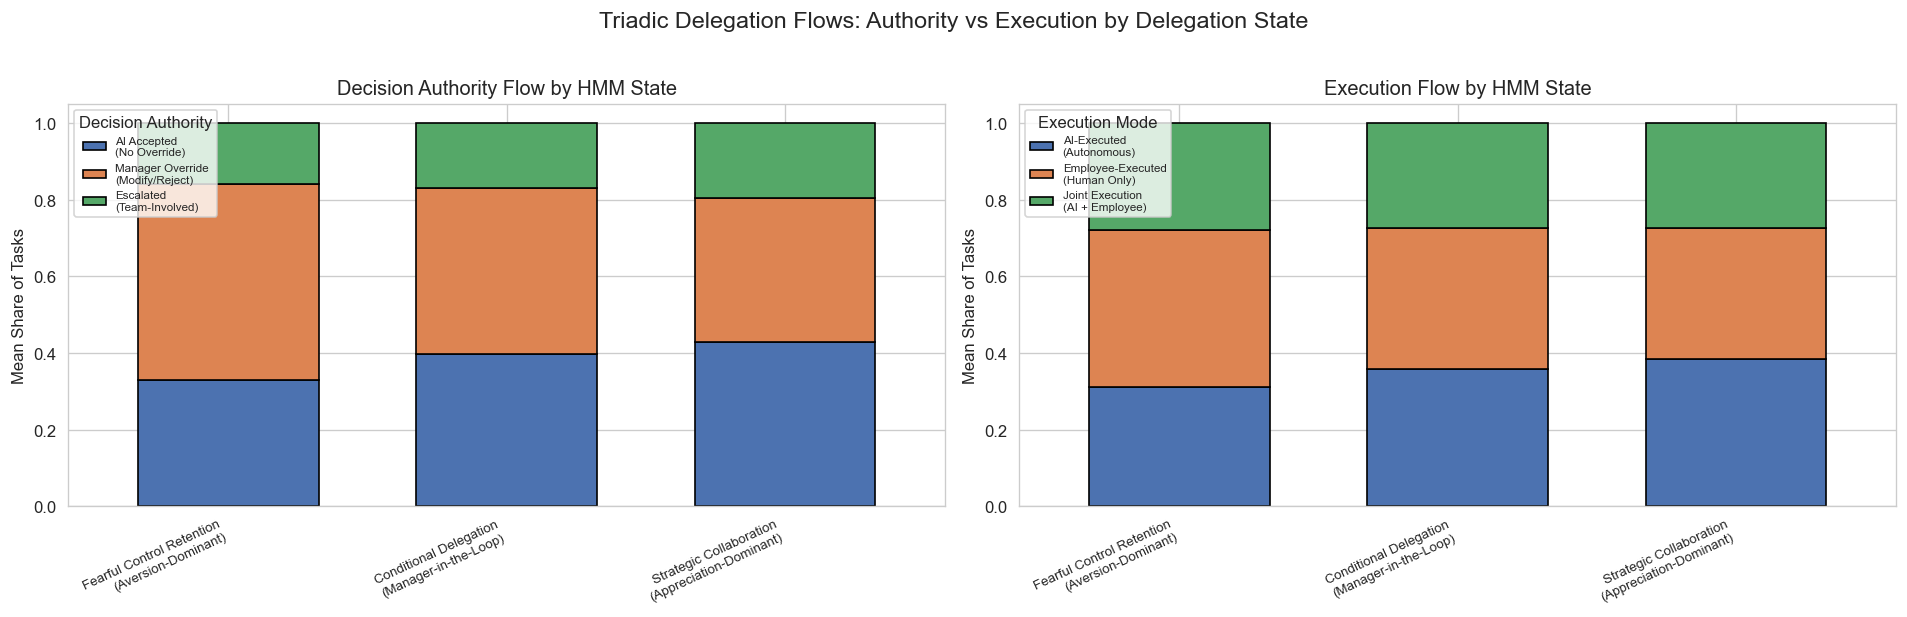


═══  Combined Authority × Execution Cross-Table by State  ═══

── Fearful Control Retention
(Aversion-Dominant) ── (33,361 tasks)


,AI-Executed,Employee-Executed,Joint
Decision Authority,,,
AI Accepted (No Override),0.6467,0.1033,0.2500
Manager Override,0.1003,0.6025,0.2972
Escalated (Team-Involved),0.2898,0.4263,0.2838



── Conditional Delegation
(Manager-in-the-Loop) ── (57,653 tasks)


,AI-Executed,Employee-Executed,Joint
Decision Authority,,,
AI Accepted (No Override),0.6526,0.1010,0.2464
Manager Override,0.1007,0.5988,0.3005
Escalated (Team-Involved),0.3275,0.3933,0.2792



── Strategic Collaboration
(Appreciation-Dominant) ── (40,048 tasks)


,AI-Executed,Employee-Executed,Joint
Decision Authority,,,
AI Accepted (No Override),0.6524,0.0986,0.2489
Manager Override,0.0984,0.5998,0.3018
Escalated (Team-Involved),0.3449,0.3806,0.2745



═══  Kruskal-Wallis: Authority AI Share Across States  ═══

H = 66.93, p = 0.000000
  → Authority flows differ significantly across HMM states (p < 0.05)

═══  Chi-Squared: Majority-AI-Authority × HMM State  ═══

χ² = 78.59, p = 0.000000, dof = 2

═══  Employee Override During Execution by State  ═══



,Mean Override Rate,Std,Count
state_label,,,
Fearful Control Retention\n(Aversion-Dominant),0.0393,0.0307,794
Conditional Delegation\n(Manager-in-the-Loop),0.0411,0.0312,1288
Strategic Collaboration\n(Appreciation-Dominant),0.0412,0.0323,918


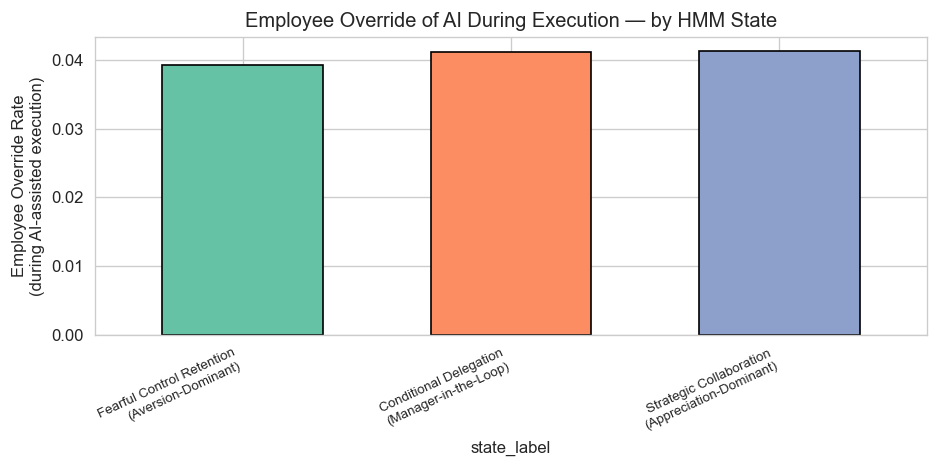


════════════════════════════════════════════════════════════
✓ Section 5.3 complete: Triadic delegation flows confirm that
  authority (who decides) and execution (who acts) are distinct
  dimensions that vary systematically across HMM delegation states.
════════════════════════════════════════════════════════════


In [71]:
# ============================================================
# 5.3  Triadic Delegation Flows — Task-Level Evidence
# ============================================================
# Load task-level tables (decision_episode & execution_episode)
# and aggregate per manager-period for triadic flow analysis.
# ============================================================

print("═══  Loading Task-Level Episode Tables  ═══\n")

# ── 1. Load decision_episode ──
dec_ep = pd.read_excel(DATA_PATH, sheet_name="decision_episode")
print(f"decision_episode : {dec_ep.shape[0]:,} tasks  ({dec_ep.shape[1]} cols)")

# ── 2. Load execution_episode (read in chunks if heavy) ──
exec_ep = pd.read_excel(DATA_PATH, sheet_name="execution_episode", engine="openpyxl")
print(f"execution_episode: {exec_ep.shape[0]:,} tasks  ({exec_ep.shape[1]} cols)")

# ── 3. Create per-task AUTHORITY_ACTOR label ──
# Priority: escalation_flag first (team-involved), then manager_action
#   escalation_flag == 1          → "Escalated (Team-Involved)"
#   manager_action == "accept"    → "AI Accepted (No Override)"
#   manager_action ∈ modify/reject→ "Manager Override"
def map_authority(row):
    if row["escalation_flag"] == 1:
        return "Escalated (Team-Involved)"
    elif row["manager_action"] == "accept":
        return "AI Accepted (No Override)"
    else:  # reject or modify
        return "Manager Override"

dec_ep["authority_actor"] = dec_ep.apply(map_authority, axis=1)

# ── 4. Merge execution_mode onto decision_episode via episode_id ──
exec_mode = exec_ep[["episode_id", "execution_mode", "employee_override_during_execution"]].copy()
# Some episodes may have >1 execution (multiple employees); take mode
exec_mode_agg = (exec_mode
    .groupby("episode_id")
    .agg(execution_mode=("execution_mode", lambda x: x.mode().iloc[0]),
         any_emp_override=("employee_override_during_execution", "max"))
    .reset_index())

tasks = dec_ep.merge(exec_mode_agg, on="episode_id", how="left")
print(f"\nMerged task table: {tasks.shape[0]:,} rows")

# ── 5. Aggregate counts per manager-period ──
print("\n═══  Per Manager-Period Authority & Execution Counts  ═══\n")

auth_counts = (tasks
    .groupby(["manager_id", "period_id", "authority_actor"])
    .size()
    .unstack(fill_value=0)
    .reset_index())

# Ensure all authority columns present
for c in ["AI Accepted (No Override)", "Manager Override", "Escalated (Team-Involved)"]:
    if c not in auth_counts.columns:
        auth_counts[c] = 0

auth_counts.rename(columns={"AI Accepted (No Override)": "n_authority_ai",
                             "Manager Override": "n_authority_mgr",
                             "Escalated (Team-Involved)": "n_authority_escalated"}, inplace=True)
auth_counts["n_tasks_total"] = (auth_counts["n_authority_ai"]
                                + auth_counts["n_authority_mgr"]
                                + auth_counts["n_authority_escalated"])

exec_counts = (tasks
    .groupby(["manager_id", "period_id", "execution_mode"])
    .size()
    .unstack(fill_value=0)
    .reset_index())
exec_counts.columns.name = None

for c in ["ai", "human", "joint"]:
    if c not in exec_counts.columns:
        exec_counts[c] = 0

exec_counts.rename(columns={"ai": "n_exec_ai",
                             "human": "n_exec_employee",
                             "joint": "n_exec_joint"}, inplace=True)

# Merge authority + execution
task_agg = auth_counts.merge(exec_counts, on=["manager_id", "period_id"], how="outer").fillna(0)

# Compute shares
task_agg["share_authority_ai"]  = task_agg["n_authority_ai"]  / task_agg["n_tasks_total"]
task_agg["share_authority_mgr"] = task_agg["n_authority_mgr"] / task_agg["n_tasks_total"]
task_agg["share_authority_esc"] = task_agg["n_authority_escalated"] / task_agg["n_tasks_total"]

exec_total = task_agg["n_exec_ai"] + task_agg["n_exec_employee"] + task_agg["n_exec_joint"]
task_agg["share_exec_ai"]       = task_agg["n_exec_ai"]       / exec_total
task_agg["share_exec_employee"] = task_agg["n_exec_employee"] / exec_total
task_agg["share_exec_joint"]    = task_agg["n_exec_joint"]    / exec_total

print(task_agg[["manager_id", "period_id", "n_tasks_total",
                "share_authority_ai", "share_authority_mgr", "share_authority_esc",
                "share_exec_ai", "share_exec_employee", "share_exec_joint"]].head(8).to_string(index=False))

# ── 6. Link to HMM states ──
task_state = task_agg.merge(
    posteriors[["manager_id", "period_id", "most_likely_state"]],
    on=["manager_id", "period_id"], how="inner")

# Map state labels
task_state["state_label"] = task_state["most_likely_state"].map(STATE_LABELS)

print(f"\nTask-State merged: {task_state.shape[0]:,} manager-period obs with HMM state labels")

# ── 7. Authority Flow by HMM State ──
print("\n═══  Authority Flow Distribution by HMM State  ═══\n")

auth_by_state = task_state.groupby("state_label")[
    ["share_authority_ai", "share_authority_mgr", "share_authority_esc"]
].mean().reindex(label_order)
auth_by_state.columns = ["AI Accepted\n(No Override)",
                         "Manager Override\n(Modify/Reject)",
                         "Escalated\n(Team-Involved)"]
display(auth_by_state.round(4))

# ── 8. Execution Flow by HMM State ──
print("\n═══  Execution Flow Distribution by HMM State  ═══\n")

exec_by_state = task_state.groupby("state_label")[
    ["share_exec_ai", "share_exec_employee", "share_exec_joint"]
].mean().reindex(label_order)
exec_by_state.columns = ["AI-Executed\n(Autonomous)",
                         "Employee-Executed\n(Human Only)",
                         "Joint Execution\n(AI + Employee)"]
display(exec_by_state.round(4))

# ── 9. Visualisation: Stacked Bar Charts ──
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Authority flows
auth_by_state.plot(kind="bar", stacked=True, ax=axes[0],
                   color=["#4C72B0", "#DD8452", "#55A868"],
                   edgecolor="k", width=0.65)
axes[0].set_title("Decision Authority Flow by HMM State", fontsize=12)
axes[0].set_ylabel("Mean Share of Tasks")
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right", fontsize=8)
axes[0].legend(title="Decision Authority", fontsize=7, loc="upper left")
axes[0].set_ylim(0, 1.05)

# Execution flows
exec_by_state.plot(kind="bar", stacked=True, ax=axes[1],
                   color=["#4C72B0", "#DD8452", "#55A868"],
                   edgecolor="k", width=0.65)
axes[1].set_title("Execution Flow by HMM State", fontsize=12)
axes[1].set_ylabel("Mean Share of Tasks")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha="right", fontsize=8)
axes[1].legend(title="Execution Mode", fontsize=7, loc="upper left")
axes[1].set_ylim(0, 1.05)

plt.suptitle("Triadic Delegation Flows: Authority vs Execution by Delegation State",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ── 10. Sankey-style summary table ──
print("\n═══  Combined Authority × Execution Cross-Table by State  ═══\n")

# Merge tasks with posteriors to get state_label on every individual task
tasks_with_state = tasks.merge(
    posteriors[["manager_id", "period_id", "most_likely_state"]],
    on=["manager_id", "period_id"], how="inner")
tasks_with_state["state_label"] = tasks_with_state["most_likely_state"].map(STATE_LABELS)

for sl in label_order:
    sub_tasks = tasks_with_state[tasks_with_state["state_label"] == sl]
    if sub_tasks.shape[0] == 0:
        continue
    cross = pd.crosstab(sub_tasks["authority_actor"], sub_tasks["execution_mode"],
                        normalize="index")
    cross.index.name = "Decision Authority"
    cross.columns.name = "Execution Mode"
    cross = cross.reindex(
        index=["AI Accepted (No Override)", "Manager Override", "Escalated (Team-Involved)"],
        columns=["ai", "human", "joint"]).fillna(0)
    cross.columns = ["AI-Executed", "Employee-Executed", "Joint"]
    print(f"── {sl} ── ({sub_tasks.shape[0]:,} tasks)")
    display(cross.round(4))
    print()

# ── 11. Statistical test: are authority flows different across states? ──
print("═══  Kruskal-Wallis: Authority AI Share Across States  ═══\n")
from scipy.stats import kruskal, chi2_contingency

groups_auth = [g["share_authority_ai"].values
               for _, g in task_state.groupby("state_label")]
kw_h, kw_p = kruskal(*groups_auth)
print(f"H = {kw_h:.2f}, p = {kw_p:.6f}")
if kw_p < 0.05:
    print("  → Authority flows differ significantly across HMM states (p < 0.05)")
else:
    print("  → Not significant at α=0.05")

print("\n═══  Chi-Squared: Majority-AI-Authority × HMM State  ═══\n")
ct_auth = pd.crosstab(task_state["state_label"],
                       task_state.apply(
                           lambda r: "AI-Majority" if r["share_authority_ai"] > 0.5
                                     else "Non-AI-Majority", axis=1))
chi2, p_chi, dof, _ = chi2_contingency(ct_auth)
print(f"χ² = {chi2:.2f}, p = {p_chi:.6f}, dof = {dof}")

# ── 12. Employee override during execution by state ──
print("\n═══  Employee Override During Execution by State  ═══\n")

# Merge employee override rate
emp_override = tasks.groupby(["manager_id", "period_id"]).agg(
    emp_override_rate=("any_emp_override", "mean")
).reset_index()

task_state2 = task_state.merge(emp_override, on=["manager_id", "period_id"], how="left")

override_by_state = task_state2.groupby("state_label")["emp_override_rate"].agg(
    ["mean", "std", "count"]).reindex(label_order)
override_by_state.columns = ["Mean Override Rate", "Std", "Count"]
display(override_by_state.round(4))

fig, ax = plt.subplots(figsize=(8, 4))
override_by_state["Mean Override Rate"].plot(
    kind="bar", ax=ax, color=sns.color_palette("Set2", best_J),
    edgecolor="k", width=0.6)
ax.set_ylabel("Employee Override Rate\n(during AI-assisted execution)")
ax.set_title("Employee Override of AI During Execution — by HMM State")
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "═" * 60)
print("✓ Section 5.3 complete: Triadic delegation flows confirm that")
print("  authority (who decides) and execution (who acts) are distinct")
print("  dimensions that vary systematically across HMM delegation states.")
print("═" * 60)

## 14. Temporal Evolution of Delegation Patterns

How does the share of tasks delegated to AI, retained by managers, or escalated to employees evolve across the 25 observation periods?

- **Delegated to AI** — AI recommendation accepted without override (`authority_actor = "AI Accepted (No Override)"`)
- **Retained by Manager** — Manager overrides the AI (`authority_actor = "Manager Override"`)
- **Escalated to Employees** — Decision escalated to team (`authority_actor = "Escalated (Team-Involved)"`)

We plot the **mean share across all managers** for each period, plus a 95 % confidence band.

═══  Delegation Shares Over Time (All Managers)  ═══



,Delegated to AI (mean),Retained by Manager (mean),Escalated to Employee (mean)
Period,,,
1,0.3033,0.4792,0.2175
2,0.2997,0.4889,0.2114
3,0.2919,0.4979,0.2102
4,0.2677,0.5151,0.2171
5,0.2772,0.5024,0.2204
6,0.2993,0.4955,0.2052
7,0.3091,0.4857,0.2051
8,0.2873,0.4993,0.2134
9,0.2810,0.5017,0.2173


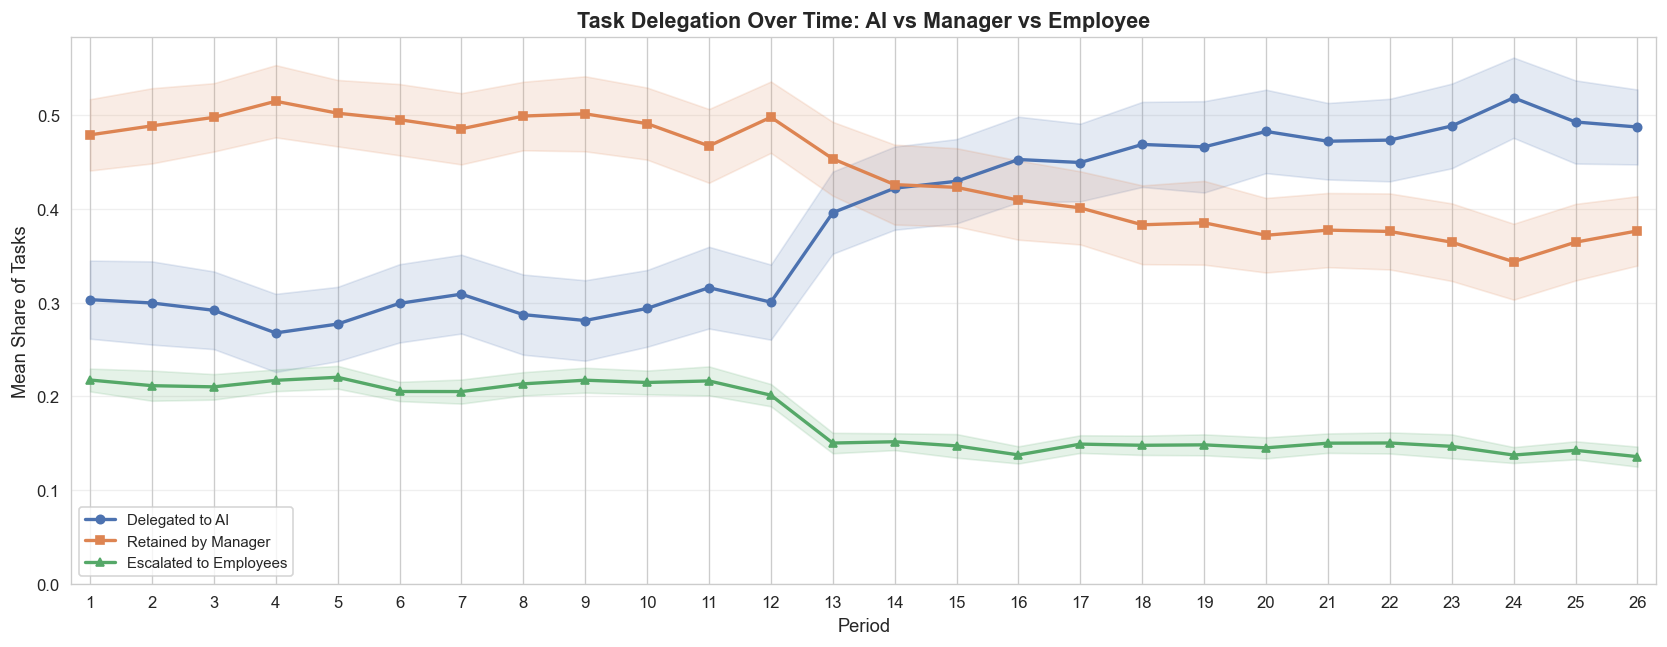

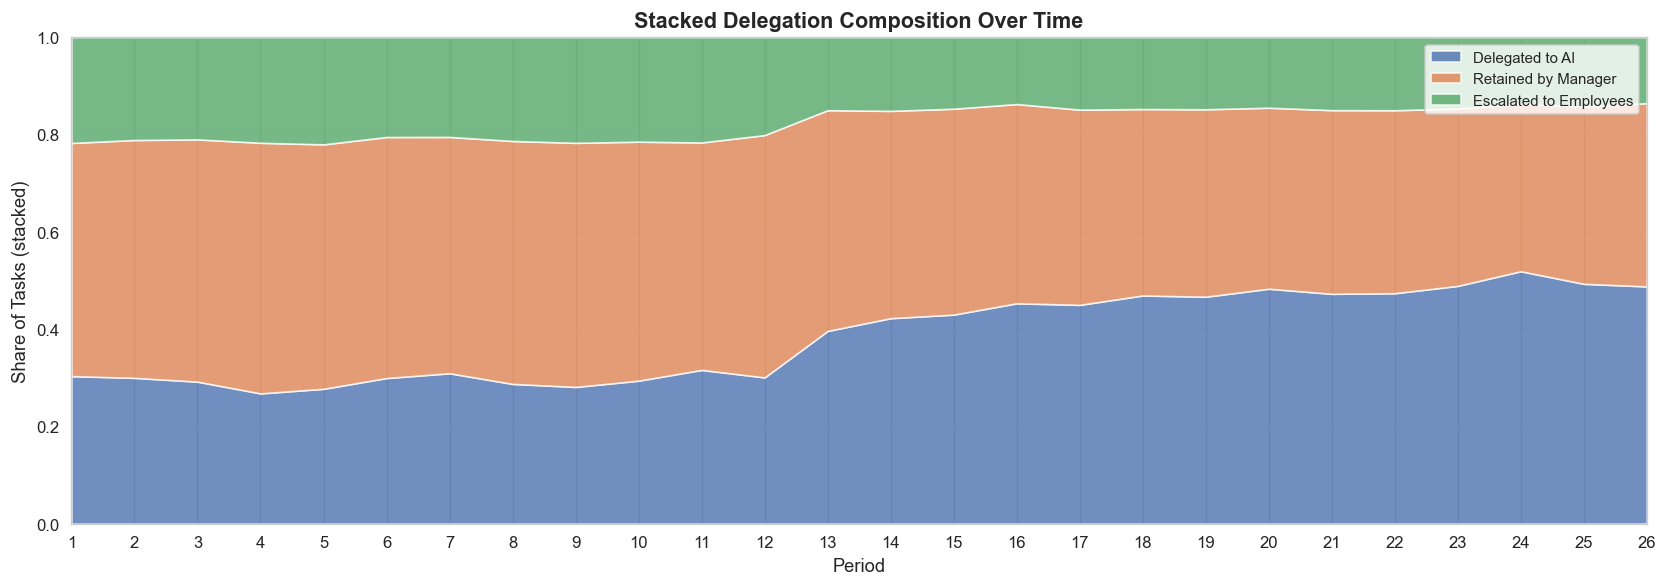

  AI delegation              ρ = +0.912  p = 0.0000  ***
  Manager retention          ρ = -0.886  p = 0.0000  ***
  Employee escalation        ρ = -0.861  p = 0.0000  ***

════════════════════════════════════════════════════════════
✓ Section 5.4 complete: Temporal delegation trends visualised.
════════════════════════════════════════════════════════════


In [72]:
# ============================================================
# 5.4  Task Delegation Over Time
# ============================================================
# Aggregate authority shares across all managers per period,
# then plot temporal evolution with confidence bands.
# ============================================================

print("═══  Delegation Shares Over Time (All Managers)  ═══\n")

# ── 1. Period-level aggregation ──
time_agg = (task_agg
    .groupby("period_id")[["share_authority_ai", "share_authority_mgr", "share_authority_esc"]]
    .agg(["mean", "std", "count"]))

# Flatten multi-index columns
periods_t = time_agg.index.values

ai_mean  = time_agg[("share_authority_ai",  "mean")].values
mgr_mean = time_agg[("share_authority_mgr", "mean")].values
esc_mean = time_agg[("share_authority_esc", "mean")].values

ai_se  = time_agg[("share_authority_ai",  "std")].values / np.sqrt(time_agg[("share_authority_ai",  "count")].values)
mgr_se = time_agg[("share_authority_mgr", "std")].values / np.sqrt(time_agg[("share_authority_mgr", "count")].values)
esc_se = time_agg[("share_authority_esc", "std")].values / np.sqrt(time_agg[("share_authority_esc", "count")].values)

# Summary table
time_summary = pd.DataFrame({
    "Period": periods_t,
    "Delegated to AI (mean)": ai_mean,
    "Retained by Manager (mean)": mgr_mean,
    "Escalated to Employee (mean)": esc_mean,
}).set_index("Period")
display(time_summary.round(4))

# ── 2. Line plot with 95% CI bands ──
fig, ax = plt.subplots(figsize=(14, 5.5))

z = 1.96  # 95% CI

# Delegated to AI
ax.plot(periods_t, ai_mean, "-o", color="#4C72B0", linewidth=2, markersize=5,
        label="Delegated to AI")
ax.fill_between(periods_t, ai_mean - z * ai_se, ai_mean + z * ai_se,
                color="#4C72B0", alpha=0.15)

# Retained by Manager
ax.plot(periods_t, mgr_mean, "-s", color="#DD8452", linewidth=2, markersize=5,
        label="Retained by Manager")
ax.fill_between(periods_t, mgr_mean - z * mgr_se, mgr_mean + z * mgr_se,
                color="#DD8452", alpha=0.15)

# Escalated to Employees
ax.plot(periods_t, esc_mean, "-^", color="#55A868", linewidth=2, markersize=5,
        label="Escalated to Employees")
ax.fill_between(periods_t, esc_mean - z * esc_se, esc_mean + z * esc_se,
                color="#55A868", alpha=0.15)

ax.set_xlabel("Period", fontsize=11)
ax.set_ylabel("Mean Share of Tasks", fontsize=11)
ax.set_title("Task Delegation Over Time: AI vs Manager vs Employee",
             fontsize=13, fontweight="bold")
ax.legend(fontsize=9, loc="best")
ax.set_xlim(periods_t.min() - 0.3, periods_t.max() + 0.3)
ax.set_ylim(0, None)
ax.set_xticks(periods_t)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ── 3. Stacked area chart ──
fig2, ax2 = plt.subplots(figsize=(14, 5))

ax2.stackplot(periods_t, ai_mean, mgr_mean, esc_mean,
              labels=["Delegated to AI", "Retained by Manager", "Escalated to Employees"],
              colors=["#4C72B0", "#DD8452", "#55A868"], alpha=0.8)

ax2.set_xlabel("Period", fontsize=11)
ax2.set_ylabel("Share of Tasks (stacked)", fontsize=11)
ax2.set_title("Stacked Delegation Composition Over Time",
              fontsize=13, fontweight="bold")
ax2.legend(loc="upper right", fontsize=9)
ax2.set_xlim(periods_t.min(), periods_t.max())
ax2.set_ylim(0, 1.0)
ax2.set_xticks(periods_t)
ax2.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ── 4. Trend test (Spearman rank correlation with period) ──
from scipy.stats import spearmanr

for label, vals in [("AI delegation", ai_mean),
                    ("Manager retention", mgr_mean),
                    ("Employee escalation", esc_mean)]:
    rho, p_val = spearmanr(periods_t, vals)
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
    print(f"  {label:25s}  ρ = {rho:+.3f}  p = {p_val:.4f}  {sig}")

print("\n" + "═" * 60)
print("✓ Section 5.4 complete: Temporal delegation trends visualised.")
print("═" * 60)